In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from time import time

In [2]:
from pandas import ewma, DataFrame, Series

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim

In [5]:
torch.__version__

'0.4.0'

In [6]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [7]:
torch.cuda.set_device(8)

In [8]:
device = torch.device('cuda' if USE_CUDA else 'cpu')

In [9]:
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

In [10]:
batch_size = 100
original_width, original_height = 28, 28
width, height = 48, 48

In [11]:
kwargs = {'num_workers': 0, 'pin_memory': True} if USE_CUDA else {}

dataset = MNIST

train_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=True, download=True, transform=transforms.Compose([
            transforms.RandomChoice(
                [transforms.Pad((i, 0, width-original_width-i, 0)) for i in range(width-original_width+1)]
            ),
            transforms.RandomChoice(
                [transforms.Pad((0, i, 0, height-original_height-i)) for i in range(height-original_height+1)]
            ),
            transforms.ToTensor()
        ])
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

test_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=False, download=True, transform=transforms.Compose([
            transforms.RandomChoice(
                [transforms.Pad((i, 0, width-original_width-i, 0)) for i in range(width-original_width+1)]
            ),
            transforms.RandomChoice(
                [transforms.Pad((0, i, 0, height-original_height-i)) for i in range(height-original_height+1)]
            ),
            transforms.ToTensor()
        ])
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

In [12]:
np.random.seed(123)

train_data = train_loader.dataset.train_data.numpy()
padded_train_data = []
for i in range(train_data.shape[0]):
    right_pad = np.random.choice(width - original_width + 1)
    bottom_pad = np.random.choice(height - original_height + 1)
    padded_train_data.append(np.pad(
        train_data[i], 
        pad_width=((width-original_width-right_pad, right_pad), (height-original_height-bottom_pad, bottom_pad)),
        mode='constant'
    ))
padded_train_data = np.array(padded_train_data)

In [13]:
print(train_loader.dataset.train_data.shape)
print(test_loader.dataset.test_data.shape)
print(padded_train_data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
(60000, 48, 48)


In [14]:
input_shape = [1, height, width]
output_size = 10

**Double backprop**

In [15]:
def constrain_loss_function(model, batch_gen, use_all_classes=False):
    X_gen, _ = next(batch_gen)
    X_gen = X_gen.to(device).requires_grad_()
    model_logits = model(X_gen) # [batch_size x num_classes]
    model_output = F.softmax(model_logits, dim=-1)
    
    if use_all_classes:
        grad_output_wrt_input_for_each_class = []
        for output in torch.unbind(torch.sum(model_output, dim=0)):
            grad_output_wrt_input_for_each_class.append(
                autograd.grad([output], [X_gen], create_graph=True)[0]
            ) # [batch_size x latent_dim]
        grad_output_wrt_input = torch.stack(
            grad_output_wrt_input_for_each_class
        ) # [num_classes x batch_size x latent_dim]
        return torch.sum(grad_output_wrt_input ** 2) / batch_size
    else:
        y = np.random.choice(output_size)
        output = torch.sum(model_output, dim=0)[y]
        grad_output_wrt_input = autograd.grad(
            [output], [X_gen], create_graph=True
        )[0]
        return output_size * torch.sum(grad_output_wrt_input ** 2) / batch_size

**Training**

In [16]:
class ReshapeLayer(nn.Module):
    def __init__(self, *args):
        super(ReshapeLayer, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)

In [20]:
class ModelConvolutional(nn.Module):
    def __init__(
        self, input_shape, output_size 
    ):
        super(type(self), self).__init__()
        #assert input_shape[1] == input_shape[2]
        self.layers = nn.ModuleList([
            ReshapeLayer(*input_shape),
            nn.Dropout(p=0.2),
            nn.Conv2d(1, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(96),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(96, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(192),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(192, 192, 3),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.AvgPool2d(10)
        ])
        self.output_layer = nn.utils.weight_norm(nn.Linear(192, 10))
        
    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        X = X.view(X.shape[0], -1)
        return self.output_layer(X)

In [18]:
train_losses = {}
train_accs = {}

test_losses = {}
test_accs = {}

run 1
eta = 100



/home/golikov/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Epoch 1 of 1000 took 3.98s;
train loss:
data term: 2.30, constrain term: 0.00, full: 2.42
train acc: 10.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 9.58

Epoch 2 of 1000 took 3.73s;
train loss:
data term: 2.29, constrain term: 0.00, full: 2.35
train acc: 8.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 9.58

Epoch 3 of 1000 took 3.74s;
train loss:
data term: 2.29, constrain term: 0.00, full: 2.33
train acc: 18.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 9.58

Epoch 4 of 1000 took 3.75s;
train loss:
data term: 2.28, constrain term: 0.00, full: 2.30
train acc: 26.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 9.58

Epoch 5 of 1000 took 3.68s;
train loss:
data term: 2.28, constrain term: 0.00, full: 2.29
train acc: 22.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 9.58

Epoch 6 of 1000 took 3.71s;
train loss:
data term: 2.27, constrain term: 0.00, full: 2.28
train acc: 26.00
test loss:
data term: 2.30, constr

Epoch 49 of 1000 took 3.72s;
train loss:
data term: 2.04, constrain term: 0.00, full: 2.04
train acc: 36.00
test loss:
data term: 2.18, constrain term: 0.00
test acc: 17.48

Epoch 50 of 1000 took 3.84s;
train loss:
data term: 2.03, constrain term: 0.00, full: 2.03
train acc: 32.00
test loss:
data term: 2.17, constrain term: 0.00
test acc: 18.06

Epoch 51 of 1000 took 3.79s;
train loss:
data term: 2.02, constrain term: 0.00, full: 2.09
train acc: 36.00
test loss:
data term: 2.16, constrain term: 0.00
test acc: 21.57

Epoch 52 of 1000 took 3.76s;
train loss:
data term: 2.02, constrain term: 0.00, full: 2.03
train acc: 36.00
test loss:
data term: 2.14, constrain term: 0.00
test acc: 24.48

Epoch 53 of 1000 took 3.86s;
train loss:
data term: 2.01, constrain term: 0.00, full: 2.01
train acc: 36.00
test loss:
data term: 2.13, constrain term: 0.00
test acc: 25.42

Epoch 54 of 1000 took 3.80s;
train loss:
data term: 2.01, constrain term: 0.00, full: 2.01
train acc: 32.00
test loss:
data term: 

Epoch 97 of 1000 took 3.79s;
train loss:
data term: 1.68, constrain term: 0.00, full: 1.76
train acc: 64.00
test loss:
data term: 1.94, constrain term: 0.00
test acc: 38.44

Epoch 98 of 1000 took 3.72s;
train loss:
data term: 1.66, constrain term: 0.00, full: 1.67
train acc: 62.00
test loss:
data term: 1.93, constrain term: 0.00
test acc: 39.30

Epoch 99 of 1000 took 3.72s;
train loss:
data term: 1.68, constrain term: 0.00, full: 1.68
train acc: 62.00
test loss:
data term: 1.92, constrain term: 0.00
test acc: 40.02

Epoch 100 of 1000 took 3.81s;
train loss:
data term: 1.67, constrain term: 0.00, full: 1.68
train acc: 64.00
test loss:
data term: 1.92, constrain term: 0.00
test acc: 39.48

Epoch 101 of 1000 took 3.77s;
train loss:
data term: 1.64, constrain term: 0.00, full: 1.65
train acc: 68.00
test loss:
data term: 1.93, constrain term: 0.00
test acc: 38.30

Epoch 102 of 1000 took 3.85s;
train loss:
data term: 1.64, constrain term: 0.00, full: 1.83
train acc: 72.00
test loss:
data ter

Epoch 144 of 1000 took 3.74s;
train loss:
data term: 1.44, constrain term: 0.00, full: 1.56
train acc: 80.00
test loss:
data term: 1.82, constrain term: 0.00
test acc: 40.25

Epoch 145 of 1000 took 3.75s;
train loss:
data term: 1.43, constrain term: 0.00, full: 1.44
train acc: 82.00
test loss:
data term: 1.83, constrain term: 0.00
test acc: 39.27

Epoch 146 of 1000 took 3.62s;
train loss:
data term: 1.43, constrain term: 0.00, full: 1.52
train acc: 82.00
test loss:
data term: 1.82, constrain term: 0.00
test acc: 40.55

Epoch 147 of 1000 took 4.09s;
train loss:
data term: 1.42, constrain term: 0.00, full: 1.43
train acc: 80.00
test loss:
data term: 1.80, constrain term: 0.00
test acc: 44.07

Epoch 148 of 1000 took 3.81s;
train loss:
data term: 1.40, constrain term: 0.00, full: 1.40
train acc: 80.00
test loss:
data term: 1.79, constrain term: 0.00
test acc: 47.23

Epoch 149 of 1000 took 3.80s;
train loss:
data term: 1.38, constrain term: 0.00, full: 1.39
train acc: 84.00
test loss:
data 

Epoch 191 of 1000 took 3.80s;
train loss:
data term: 1.28, constrain term: 0.00, full: 1.47
train acc: 82.00
test loss:
data term: 1.72, constrain term: 0.00
test acc: 52.01

Epoch 192 of 1000 took 3.62s;
train loss:
data term: 1.28, constrain term: 0.00, full: 1.45
train acc: 84.00
test loss:
data term: 1.71, constrain term: 0.00
test acc: 52.74

Epoch 193 of 1000 took 4.01s;
train loss:
data term: 1.28, constrain term: 0.00, full: 1.31
train acc: 84.00
test loss:
data term: 1.71, constrain term: 0.00
test acc: 53.31

Epoch 194 of 1000 took 3.86s;
train loss:
data term: 1.30, constrain term: 0.00, full: 1.36
train acc: 82.00
test loss:
data term: 1.71, constrain term: 0.00
test acc: 52.77

Epoch 195 of 1000 took 3.70s;
train loss:
data term: 1.28, constrain term: 0.00, full: 1.40
train acc: 84.00
test loss:
data term: 1.71, constrain term: 0.00
test acc: 52.03

Epoch 196 of 1000 took 3.72s;
train loss:
data term: 1.30, constrain term: 0.00, full: 1.31
train acc: 84.00
test loss:
data 

Epoch 238 of 1000 took 3.88s;
train loss:
data term: 1.16, constrain term: 0.00, full: 1.40
train acc: 90.00
test loss:
data term: 1.66, constrain term: 0.00
test acc: 54.60

Epoch 239 of 1000 took 3.98s;
train loss:
data term: 1.17, constrain term: 0.00, full: 1.26
train acc: 86.00
test loss:
data term: 1.64, constrain term: 0.00
test acc: 54.90

Epoch 240 of 1000 took 3.92s;
train loss:
data term: 1.17, constrain term: 0.00, full: 1.18
train acc: 88.00
test loss:
data term: 1.63, constrain term: 0.00
test acc: 56.10

Epoch 241 of 1000 took 3.89s;
train loss:
data term: 1.16, constrain term: 0.00, full: 1.23
train acc: 90.00
test loss:
data term: 1.62, constrain term: 0.00
test acc: 57.57

Epoch 242 of 1000 took 3.82s;
train loss:
data term: 1.17, constrain term: 0.00, full: 1.35
train acc: 90.00
test loss:
data term: 1.61, constrain term: 0.00
test acc: 57.39

Epoch 243 of 1000 took 3.75s;
train loss:
data term: 1.16, constrain term: 0.00, full: 1.29
train acc: 86.00
test loss:
data 

Epoch 285 of 1000 took 3.80s;
train loss:
data term: 1.10, constrain term: 0.00, full: 1.16
train acc: 90.00
test loss:
data term: 1.62, constrain term: 0.00
test acc: 49.88

Epoch 286 of 1000 took 3.69s;
train loss:
data term: 1.08, constrain term: 0.00, full: 1.34
train acc: 92.00
test loss:
data term: 1.60, constrain term: 0.00
test acc: 50.55

Epoch 287 of 1000 took 3.74s;
train loss:
data term: 1.08, constrain term: 0.00, full: 1.34
train acc: 92.00
test loss:
data term: 1.64, constrain term: 0.00
test acc: 44.44

Epoch 288 of 1000 took 3.94s;
train loss:
data term: 1.11, constrain term: 0.00, full: 1.12
train acc: 92.00
test loss:
data term: 1.67, constrain term: 0.00
test acc: 41.42

Epoch 289 of 1000 took 3.80s;
train loss:
data term: 1.13, constrain term: 0.00, full: 1.18
train acc: 90.00
test loss:
data term: 1.66, constrain term: 0.00
test acc: 42.94

Epoch 290 of 1000 took 3.93s;
train loss:
data term: 1.12, constrain term: 0.00, full: 1.14
train acc: 94.00
test loss:
data 

Epoch 332 of 1000 took 3.84s;
train loss:
data term: 1.04, constrain term: 0.00, full: 1.09
train acc: 90.00
test loss:
data term: 1.53, constrain term: 0.00
test acc: 58.68

Epoch 333 of 1000 took 3.77s;
train loss:
data term: 1.02, constrain term: 0.00, full: 1.22
train acc: 92.00
test loss:
data term: 1.53, constrain term: 0.00
test acc: 58.55

Epoch 334 of 1000 took 3.70s;
train loss:
data term: 1.02, constrain term: 0.00, full: 1.35
train acc: 92.00
test loss:
data term: 1.52, constrain term: 0.00
test acc: 60.89

Epoch 335 of 1000 took 3.88s;
train loss:
data term: 1.02, constrain term: 0.00, full: 1.04
train acc: 94.00
test loss:
data term: 1.52, constrain term: 0.00
test acc: 61.43

Epoch 336 of 1000 took 3.90s;
train loss:
data term: 0.99, constrain term: 0.00, full: 1.07
train acc: 96.00
test loss:
data term: 1.54, constrain term: 0.00
test acc: 60.08

Epoch 337 of 1000 took 3.74s;
train loss:
data term: 1.01, constrain term: 0.00, full: 1.21
train acc: 94.00
test loss:
data 

Epoch 379 of 1000 took 3.79s;
train loss:
data term: 0.98, constrain term: 0.00, full: 1.13
train acc: 98.00
test loss:
data term: 1.60, constrain term: 0.00
test acc: 51.13

Epoch 380 of 1000 took 4.08s;
train loss:
data term: 0.97, constrain term: 0.00, full: 1.02
train acc: 96.00
test loss:
data term: 1.64, constrain term: 0.00
test acc: 48.31

Epoch 381 of 1000 took 3.58s;
train loss:
data term: 0.98, constrain term: 0.00, full: 1.09
train acc: 98.00
test loss:
data term: 1.65, constrain term: 0.00
test acc: 48.09

Epoch 382 of 1000 took 3.56s;
train loss:
data term: 0.98, constrain term: 0.00, full: 1.00
train acc: 96.00
test loss:
data term: 1.63, constrain term: 0.00
test acc: 50.58

Epoch 383 of 1000 took 3.56s;
train loss:
data term: 0.97, constrain term: 0.00, full: 0.98
train acc: 98.00
test loss:
data term: 1.59, constrain term: 0.00
test acc: 54.30

Epoch 384 of 1000 took 3.57s;
train loss:
data term: 0.95, constrain term: 0.00, full: 0.96
train acc: 98.00
test loss:
data 

Epoch 426 of 1000 took 3.62s;
train loss:
data term: 0.89, constrain term: 0.00, full: 0.90
train acc: 98.00
test loss:
data term: 1.49, constrain term: 0.00
test acc: 60.16

Epoch 427 of 1000 took 3.63s;
train loss:
data term: 0.89, constrain term: 0.00, full: 1.04
train acc: 98.00
test loss:
data term: 1.49, constrain term: 0.00
test acc: 59.90

Epoch 428 of 1000 took 3.65s;
train loss:
data term: 0.88, constrain term: 0.00, full: 1.13
train acc: 98.00
test loss:
data term: 1.51, constrain term: 0.00
test acc: 57.43

Epoch 429 of 1000 took 3.64s;
train loss:
data term: 0.88, constrain term: 0.00, full: 0.97
train acc: 98.00
test loss:
data term: 1.52, constrain term: 0.00
test acc: 55.38

Epoch 430 of 1000 took 3.62s;
train loss:
data term: 0.90, constrain term: 0.00, full: 0.94
train acc: 98.00
test loss:
data term: 1.51, constrain term: 0.00
test acc: 57.10

Epoch 431 of 1000 took 3.63s;
train loss:
data term: 0.89, constrain term: 0.00, full: 0.92
train acc: 98.00
test loss:
data 

Epoch 473 of 1000 took 3.59s;
train loss:
data term: 0.79, constrain term: 0.00, full: 0.85
train acc: 98.00
test loss:
data term: 1.45, constrain term: 0.00
test acc: 63.17

Epoch 474 of 1000 took 3.60s;
train loss:
data term: 0.80, constrain term: 0.00, full: 1.09
train acc: 98.00
test loss:
data term: 1.44, constrain term: 0.00
test acc: 62.78

Epoch 475 of 1000 took 3.57s;
train loss:
data term: 0.78, constrain term: 0.00, full: 0.83
train acc: 98.00
test loss:
data term: 1.43, constrain term: 0.00
test acc: 61.81

Epoch 476 of 1000 took 3.62s;
train loss:
data term: 0.78, constrain term: 0.00, full: 1.10
train acc: 98.00
test loss:
data term: 1.45, constrain term: 0.00
test acc: 57.40

Epoch 477 of 1000 took 3.74s;
train loss:
data term: 0.81, constrain term: 0.00, full: 0.85
train acc: 98.00
test loss:
data term: 1.47, constrain term: 0.00
test acc: 55.29

Epoch 478 of 1000 took 3.85s;
train loss:
data term: 0.80, constrain term: 0.00, full: 1.09
train acc: 98.00
test loss:
data 

Epoch 520 of 1000 took 3.65s;
train loss:
data term: 0.85, constrain term: 0.00, full: 1.05
train acc: 98.00
test loss:
data term: 2.28, constrain term: 0.00
test acc: 20.92

Epoch 521 of 1000 took 3.74s;
train loss:
data term: 0.88, constrain term: 0.00, full: 0.91
train acc: 98.00
test loss:
data term: 2.03, constrain term: 0.00
test acc: 21.93

Epoch 522 of 1000 took 3.67s;
train loss:
data term: 0.87, constrain term: 0.00, full: 0.96
train acc: 98.00
test loss:
data term: 1.76, constrain term: 0.00
test acc: 31.59

Epoch 523 of 1000 took 4.16s;
train loss:
data term: 0.86, constrain term: 0.00, full: 1.08
train acc: 98.00
test loss:
data term: 1.61, constrain term: 0.00
test acc: 45.64

Epoch 524 of 1000 took 3.73s;
train loss:
data term: 0.84, constrain term: 0.00, full: 0.85
train acc: 98.00
test loss:
data term: 1.53, constrain term: 0.00
test acc: 54.27

Epoch 525 of 1000 took 3.67s;
train loss:
data term: 0.84, constrain term: 0.00, full: 0.92
train acc: 98.00
test loss:
data 

Epoch 567 of 1000 took 3.72s;
train loss:
data term: 0.75, constrain term: 0.00, full: 0.81
train acc: 98.00
test loss:
data term: 1.40, constrain term: 0.00
test acc: 64.78

Epoch 568 of 1000 took 3.62s;
train loss:
data term: 0.75, constrain term: 0.00, full: 0.82
train acc: 98.00
test loss:
data term: 1.39, constrain term: 0.00
test acc: 67.03

Epoch 569 of 1000 took 3.75s;
train loss:
data term: 0.73, constrain term: 0.00, full: 0.80
train acc: 98.00
test loss:
data term: 1.39, constrain term: 0.00
test acc: 68.83

Epoch 570 of 1000 took 4.00s;
train loss:
data term: 0.74, constrain term: 0.00, full: 0.82
train acc: 98.00
test loss:
data term: 1.39, constrain term: 0.00
test acc: 69.69

Epoch 571 of 1000 took 3.94s;
train loss:
data term: 0.73, constrain term: 0.00, full: 1.01
train acc: 98.00
test loss:
data term: 1.37, constrain term: 0.00
test acc: 71.25

Epoch 572 of 1000 took 3.86s;
train loss:
data term: 0.73, constrain term: 0.00, full: 0.79
train acc: 98.00
test loss:
data 

Epoch 614 of 1000 took 4.02s;
train loss:
data term: 0.73, constrain term: 0.00, full: 0.73
train acc: 98.00
test loss:
data term: 1.43, constrain term: 0.00
test acc: 66.07

Epoch 615 of 1000 took 3.79s;
train loss:
data term: 0.71, constrain term: 0.00, full: 0.79
train acc: 98.00
test loss:
data term: 1.43, constrain term: 0.00
test acc: 67.02

Epoch 616 of 1000 took 3.98s;
train loss:
data term: 0.71, constrain term: 0.00, full: 0.77
train acc: 98.00
test loss:
data term: 1.45, constrain term: 0.00
test acc: 65.26

Epoch 617 of 1000 took 3.95s;
train loss:
data term: 0.70, constrain term: 0.00, full: 0.76
train acc: 98.00
test loss:
data term: 1.46, constrain term: 0.00
test acc: 64.90

Epoch 618 of 1000 took 3.87s;
train loss:
data term: 0.68, constrain term: 0.00, full: 0.69
train acc: 98.00
test loss:
data term: 1.47, constrain term: 0.00
test acc: 64.46

Epoch 619 of 1000 took 3.83s;
train loss:
data term: 0.69, constrain term: 0.00, full: 0.83
train acc: 98.00
test loss:
data 

Epoch 661 of 1000 took 3.78s;
train loss:
data term: 0.66, constrain term: 0.00, full: 0.71
train acc: 98.00
test loss:
data term: 1.38, constrain term: 0.00
test acc: 66.45

Epoch 662 of 1000 took 3.82s;
train loss:
data term: 0.67, constrain term: 0.00, full: 0.79
train acc: 98.00
test loss:
data term: 1.36, constrain term: 0.00
test acc: 69.68

Epoch 663 of 1000 took 3.70s;
train loss:
data term: 0.66, constrain term: 0.00, full: 0.79
train acc: 98.00
test loss:
data term: 1.33, constrain term: 0.00
test acc: 72.77

Epoch 664 of 1000 took 3.63s;
train loss:
data term: 0.65, constrain term: 0.00, full: 0.66
train acc: 98.00
test loss:
data term: 1.32, constrain term: 0.00
test acc: 72.42

Epoch 665 of 1000 took 3.88s;
train loss:
data term: 0.65, constrain term: 0.00, full: 1.02
train acc: 98.00
test loss:
data term: 1.32, constrain term: 0.00
test acc: 69.74

Epoch 666 of 1000 took 3.70s;
train loss:
data term: 0.65, constrain term: 0.00, full: 0.95
train acc: 98.00
test loss:
data 

Epoch 708 of 1000 took 3.83s;
train loss:
data term: 0.66, constrain term: 0.00, full: 0.75
train acc: 98.00
test loss:
data term: 1.33, constrain term: 0.00
test acc: 68.97

Epoch 709 of 1000 took 4.15s;
train loss:
data term: 0.67, constrain term: 0.00, full: 0.78
train acc: 98.00
test loss:
data term: 1.33, constrain term: 0.00
test acc: 68.62

Epoch 710 of 1000 took 3.76s;
train loss:
data term: 0.68, constrain term: 0.00, full: 0.69
train acc: 98.00
test loss:
data term: 1.34, constrain term: 0.00
test acc: 67.66

Epoch 711 of 1000 took 4.27s;
train loss:
data term: 0.66, constrain term: 0.00, full: 0.74
train acc: 98.00
test loss:
data term: 1.35, constrain term: 0.00
test acc: 67.81

Epoch 712 of 1000 took 4.29s;
train loss:
data term: 0.66, constrain term: 0.00, full: 0.83
train acc: 98.00
test loss:
data term: 1.37, constrain term: 0.00
test acc: 66.89

Epoch 713 of 1000 took 4.21s;
train loss:
data term: 0.65, constrain term: 0.00, full: 0.76
train acc: 98.00
test loss:
data 

Epoch 755 of 1000 took 3.69s;
train loss:
data term: 0.60, constrain term: 0.00, full: 0.77
train acc: 98.00
test loss:
data term: 1.27, constrain term: 0.00
test acc: 72.98

Epoch 756 of 1000 took 3.66s;
train loss:
data term: 0.61, constrain term: 0.00, full: 0.61
train acc: 98.00
test loss:
data term: 1.27, constrain term: 0.00
test acc: 74.49

Epoch 757 of 1000 took 3.88s;
train loss:
data term: 0.61, constrain term: 0.00, full: 0.71
train acc: 98.00
test loss:
data term: 1.28, constrain term: 0.00
test acc: 74.94

Epoch 758 of 1000 took 3.65s;
train loss:
data term: 0.60, constrain term: 0.00, full: 0.85
train acc: 98.00
test loss:
data term: 1.28, constrain term: 0.00
test acc: 74.28

Epoch 759 of 1000 took 3.85s;
train loss:
data term: 0.61, constrain term: 0.00, full: 0.85
train acc: 98.00
test loss:
data term: 1.28, constrain term: 0.00
test acc: 74.06

Epoch 760 of 1000 took 3.90s;
train loss:
data term: 0.63, constrain term: 0.00, full: 0.77
train acc: 98.00
test loss:
data 

Epoch 802 of 1000 took 3.89s;
train loss:
data term: 0.60, constrain term: 0.00, full: 0.80
train acc: 98.00
test loss:
data term: 1.36, constrain term: 0.00
test acc: 68.10

Epoch 803 of 1000 took 3.93s;
train loss:
data term: 0.61, constrain term: 0.00, full: 0.62
train acc: 98.00
test loss:
data term: 1.36, constrain term: 0.00
test acc: 67.88

Epoch 804 of 1000 took 4.01s;
train loss:
data term: 0.60, constrain term: 0.00, full: 0.72
train acc: 98.00
test loss:
data term: 1.35, constrain term: 0.00
test acc: 68.10

Epoch 805 of 1000 took 4.04s;
train loss:
data term: 0.59, constrain term: 0.00, full: 0.76
train acc: 98.00
test loss:
data term: 1.34, constrain term: 0.00
test acc: 68.65

Epoch 806 of 1000 took 3.80s;
train loss:
data term: 0.59, constrain term: 0.00, full: 0.75
train acc: 98.00
test loss:
data term: 1.31, constrain term: 0.00
test acc: 70.68

Epoch 807 of 1000 took 3.68s;
train loss:
data term: 0.60, constrain term: 0.00, full: 0.69
train acc: 98.00
test loss:
data 

Epoch 849 of 1000 took 3.98s;
train loss:
data term: 0.59, constrain term: 0.00, full: 0.68
train acc: 98.00
test loss:
data term: 1.30, constrain term: 0.00
test acc: 67.47

Epoch 850 of 1000 took 3.75s;
train loss:
data term: 0.60, constrain term: 0.00, full: 0.71
train acc: 98.00
test loss:
data term: 1.33, constrain term: 0.00
test acc: 66.21

Epoch 851 of 1000 took 3.73s;
train loss:
data term: 0.60, constrain term: 0.00, full: 0.69
train acc: 98.00
test loss:
data term: 1.34, constrain term: 0.00
test acc: 65.73

Epoch 852 of 1000 took 3.87s;
train loss:
data term: 0.62, constrain term: 0.00, full: 0.83
train acc: 98.00
test loss:
data term: 1.35, constrain term: 0.00
test acc: 65.93

Epoch 853 of 1000 took 3.77s;
train loss:
data term: 0.60, constrain term: 0.00, full: 0.70
train acc: 98.00
test loss:
data term: 1.34, constrain term: 0.00
test acc: 66.95

Epoch 854 of 1000 took 3.92s;
train loss:
data term: 0.60, constrain term: 0.00, full: 0.76
train acc: 98.00
test loss:
data 

Epoch 896 of 1000 took 4.70s;
train loss:
data term: 0.57, constrain term: 0.00, full: 0.84
train acc: 98.00
test loss:
data term: 1.33, constrain term: 0.00
test acc: 67.31

Epoch 897 of 1000 took 3.95s;
train loss:
data term: 0.56, constrain term: 0.00, full: 0.74
train acc: 98.00
test loss:
data term: 1.35, constrain term: 0.00
test acc: 65.71

Epoch 898 of 1000 took 3.94s;
train loss:
data term: 0.59, constrain term: 0.00, full: 0.67
train acc: 98.00
test loss:
data term: 1.38, constrain term: 0.00
test acc: 63.04

Epoch 899 of 1000 took 4.01s;
train loss:
data term: 0.58, constrain term: 0.00, full: 0.64
train acc: 98.00
test loss:
data term: 1.41, constrain term: 0.00
test acc: 60.93

Epoch 900 of 1000 took 3.82s;
train loss:
data term: 0.59, constrain term: 0.00, full: 0.63
train acc: 98.00
test loss:
data term: 1.42, constrain term: 0.00
test acc: 60.32

Epoch 901 of 1000 took 3.86s;
train loss:
data term: 0.58, constrain term: 0.00, full: 0.93
train acc: 98.00
test loss:
data 

Epoch 943 of 1000 took 3.74s;
train loss:
data term: 0.57, constrain term: 0.00, full: 0.65
train acc: 98.00
test loss:
data term: 1.40, constrain term: 0.00
test acc: 61.21

Epoch 944 of 1000 took 4.10s;
train loss:
data term: 0.57, constrain term: 0.00, full: 0.74
train acc: 98.00
test loss:
data term: 1.37, constrain term: 0.00
test acc: 63.13

Epoch 945 of 1000 took 3.77s;
train loss:
data term: 0.54, constrain term: 0.00, full: 0.55
train acc: 98.00
test loss:
data term: 1.36, constrain term: 0.00
test acc: 64.72

Epoch 946 of 1000 took 3.74s;
train loss:
data term: 0.55, constrain term: 0.00, full: 0.64
train acc: 98.00
test loss:
data term: 1.35, constrain term: 0.00
test acc: 65.77

Epoch 947 of 1000 took 3.75s;
train loss:
data term: 0.54, constrain term: 0.00, full: 0.63
train acc: 98.00
test loss:
data term: 1.33, constrain term: 0.00
test acc: 67.54

Epoch 948 of 1000 took 3.92s;
train loss:
data term: 0.54, constrain term: 0.00, full: 0.68
train acc: 98.00
test loss:
data 

Epoch 990 of 1000 took 3.89s;
train loss:
data term: 0.57, constrain term: 0.00, full: 0.70
train acc: 98.00
test loss:
data term: 1.31, constrain term: 0.00
test acc: 70.76

Epoch 991 of 1000 took 3.72s;
train loss:
data term: 0.58, constrain term: 0.00, full: 0.73
train acc: 98.00
test loss:
data term: 1.33, constrain term: 0.00
test acc: 69.72

Epoch 992 of 1000 took 3.77s;
train loss:
data term: 0.59, constrain term: 0.00, full: 0.68
train acc: 98.00
test loss:
data term: 1.35, constrain term: 0.00
test acc: 67.96

Epoch 993 of 1000 took 3.71s;
train loss:
data term: 0.55, constrain term: 0.00, full: 0.65
train acc: 98.00
test loss:
data term: 1.37, constrain term: 0.00
test acc: 66.40

Epoch 994 of 1000 took 4.03s;
train loss:
data term: 0.55, constrain term: 0.00, full: 0.60
train acc: 98.00
test loss:
data term: 1.38, constrain term: 0.00
test acc: 65.38

Epoch 995 of 1000 took 3.84s;
train loss:
data term: 0.55, constrain term: 0.00, full: 0.66
train acc: 98.00
test loss:
data 

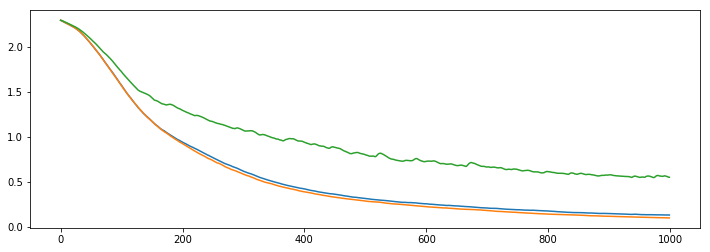

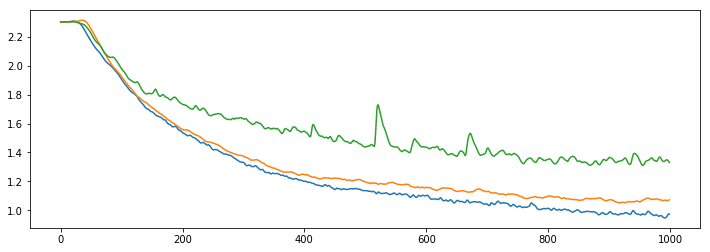

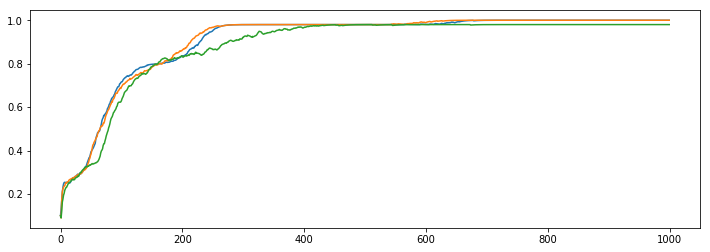

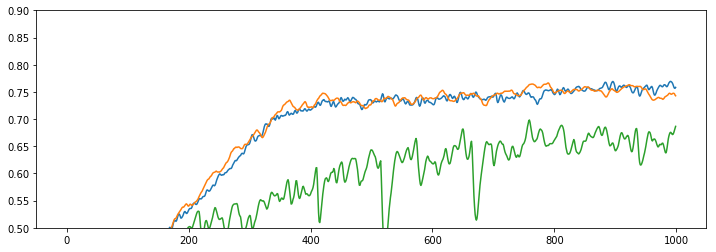

eta = 10

Epoch 1 of 1000 took 3.75s;
train loss:
data term: 2.30, constrain term: 0.00, full: 2.31
train acc: 10.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 9.58

Epoch 2 of 1000 took 3.84s;
train loss:
data term: 2.29, constrain term: 0.00, full: 2.30
train acc: 16.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 9.58

Epoch 3 of 1000 took 3.94s;
train loss:
data term: 2.29, constrain term: 0.00, full: 2.29
train acc: 22.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 9.58

Epoch 4 of 1000 took 3.99s;
train loss:
data term: 2.28, constrain term: 0.00, full: 2.28
train acc: 30.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 9.58

Epoch 5 of 1000 took 3.68s;
train loss:
data term: 2.27, constrain term: 0.00, full: 2.28
train acc: 24.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 9.58

Epoch 6 of 1000 took 3.71s;
train loss:
data term: 2.26, constrain term: 0.00, full: 2.27
train acc: 28.00
test loss:
data term: 2

Epoch 49 of 1000 took 3.67s;
train loss:
data term: 1.98, constrain term: 0.00, full: 1.98
train acc: 42.00
test loss:
data term: 2.12, constrain term: 0.00
test acc: 21.78

Epoch 50 of 1000 took 3.89s;
train loss:
data term: 1.97, constrain term: 0.00, full: 1.97
train acc: 50.00
test loss:
data term: 2.12, constrain term: 0.00
test acc: 22.18

Epoch 51 of 1000 took 3.86s;
train loss:
data term: 1.96, constrain term: 0.00, full: 2.01
train acc: 48.00
test loss:
data term: 2.11, constrain term: 0.00
test acc: 23.94

Epoch 52 of 1000 took 3.83s;
train loss:
data term: 1.96, constrain term: 0.00, full: 1.96
train acc: 46.00
test loss:
data term: 2.10, constrain term: 0.00
test acc: 25.55

Epoch 53 of 1000 took 3.60s;
train loss:
data term: 1.94, constrain term: 0.00, full: 1.95
train acc: 44.00
test loss:
data term: 2.10, constrain term: 0.00
test acc: 26.29

Epoch 54 of 1000 took 3.93s;
train loss:
data term: 1.95, constrain term: 0.00, full: 1.95
train acc: 46.00
test loss:
data term: 

Epoch 97 of 1000 took 3.84s;
train loss:
data term: 1.54, constrain term: 0.00, full: 1.59
train acc: 74.00
test loss:
data term: 1.87, constrain term: 0.00
test acc: 40.59

Epoch 98 of 1000 took 3.71s;
train loss:
data term: 1.52, constrain term: 0.00, full: 1.53
train acc: 76.00
test loss:
data term: 1.87, constrain term: 0.00
test acc: 40.35

Epoch 99 of 1000 took 3.65s;
train loss:
data term: 1.55, constrain term: 0.00, full: 1.55
train acc: 70.00
test loss:
data term: 1.86, constrain term: 0.00
test acc: 41.08

Epoch 100 of 1000 took 3.85s;
train loss:
data term: 1.53, constrain term: 0.00, full: 1.53
train acc: 74.00
test loss:
data term: 1.86, constrain term: 0.00
test acc: 40.30

Epoch 101 of 1000 took 3.78s;
train loss:
data term: 1.50, constrain term: 0.00, full: 1.51
train acc: 74.00
test loss:
data term: 1.87, constrain term: 0.00
test acc: 38.95

Epoch 102 of 1000 took 3.98s;
train loss:
data term: 1.51, constrain term: 0.01, full: 1.59
train acc: 74.00
test loss:
data ter

Epoch 144 of 1000 took 3.88s;
train loss:
data term: 1.22, constrain term: 0.01, full: 1.30
train acc: 80.00
test loss:
data term: 1.73, constrain term: 0.00
test acc: 43.65

Epoch 145 of 1000 took 3.82s;
train loss:
data term: 1.21, constrain term: 0.00, full: 1.21
train acc: 80.00
test loss:
data term: 1.72, constrain term: 0.00
test acc: 43.64

Epoch 146 of 1000 took 3.91s;
train loss:
data term: 1.21, constrain term: 0.01, full: 1.28
train acc: 78.00
test loss:
data term: 1.71, constrain term: 0.00
test acc: 45.45

Epoch 147 of 1000 took 4.25s;
train loss:
data term: 1.20, constrain term: 0.00, full: 1.20
train acc: 80.00
test loss:
data term: 1.69, constrain term: 0.00
test acc: 47.77

Epoch 148 of 1000 took 3.83s;
train loss:
data term: 1.19, constrain term: 0.00, full: 1.19
train acc: 78.00
test loss:
data term: 1.67, constrain term: 0.00
test acc: 49.68

Epoch 149 of 1000 took 3.66s;
train loss:
data term: 1.18, constrain term: 0.00, full: 1.18
train acc: 80.00
test loss:
data 

Epoch 191 of 1000 took 4.15s;
train loss:
data term: 1.02, constrain term: 0.01, full: 1.14
train acc: 80.00
test loss:
data term: 1.57, constrain term: 0.00
test acc: 53.77

Epoch 192 of 1000 took 3.83s;
train loss:
data term: 1.02, constrain term: 0.01, full: 1.10
train acc: 82.00
test loss:
data term: 1.56, constrain term: 0.00
test acc: 53.23

Epoch 193 of 1000 took 3.90s;
train loss:
data term: 1.02, constrain term: 0.00, full: 1.03
train acc: 82.00
test loss:
data term: 1.57, constrain term: 0.00
test acc: 53.11

Epoch 194 of 1000 took 3.92s;
train loss:
data term: 1.03, constrain term: 0.00, full: 1.06
train acc: 88.00
test loss:
data term: 1.58, constrain term: 0.00
test acc: 52.22

Epoch 195 of 1000 took 3.98s;
train loss:
data term: 1.02, constrain term: 0.01, full: 1.11
train acc: 84.00
test loss:
data term: 1.58, constrain term: 0.00
test acc: 51.36

Epoch 196 of 1000 took 3.94s;
train loss:
data term: 1.04, constrain term: 0.00, full: 1.04
train acc: 86.00
test loss:
data 

Epoch 238 of 1000 took 4.07s;
train loss:
data term: 0.88, constrain term: 0.01, full: 0.95
train acc: 92.00
test loss:
data term: 1.48, constrain term: 0.00
test acc: 56.26

Epoch 239 of 1000 took 3.97s;
train loss:
data term: 0.87, constrain term: 0.00, full: 0.91
train acc: 94.00
test loss:
data term: 1.47, constrain term: 0.00
test acc: 56.75

Epoch 240 of 1000 took 3.80s;
train loss:
data term: 0.87, constrain term: 0.00, full: 0.88
train acc: 94.00
test loss:
data term: 1.46, constrain term: 0.00
test acc: 57.38

Epoch 241 of 1000 took 4.05s;
train loss:
data term: 0.86, constrain term: 0.00, full: 0.88
train acc: 96.00
test loss:
data term: 1.45, constrain term: 0.00
test acc: 58.72

Epoch 242 of 1000 took 3.75s;
train loss:
data term: 0.87, constrain term: 0.01, full: 0.96
train acc: 94.00
test loss:
data term: 1.46, constrain term: 0.00
test acc: 57.40

Epoch 243 of 1000 took 3.93s;
train loss:
data term: 0.87, constrain term: 0.01, full: 0.92
train acc: 92.00
test loss:
data 

Epoch 285 of 1000 took 3.99s;
train loss:
data term: 0.75, constrain term: 0.00, full: 0.78
train acc: 98.00
test loss:
data term: 1.40, constrain term: 0.00
test acc: 59.46

Epoch 286 of 1000 took 3.91s;
train loss:
data term: 0.74, constrain term: 0.01, full: 0.86
train acc: 98.00
test loss:
data term: 1.39, constrain term: 0.00
test acc: 61.10

Epoch 287 of 1000 took 3.95s;
train loss:
data term: 0.75, constrain term: 0.01, full: 0.89
train acc: 98.00
test loss:
data term: 1.46, constrain term: 0.00
test acc: 55.35

Epoch 288 of 1000 took 3.86s;
train loss:
data term: 0.76, constrain term: 0.00, full: 0.76
train acc: 98.00
test loss:
data term: 1.49, constrain term: 0.00
test acc: 53.92

Epoch 289 of 1000 took 3.82s;
train loss:
data term: 0.79, constrain term: 0.00, full: 0.81
train acc: 96.00
test loss:
data term: 1.43, constrain term: 0.00
test acc: 58.33

Epoch 290 of 1000 took 3.74s;
train loss:
data term: 0.76, constrain term: 0.00, full: 0.78
train acc: 96.00
test loss:
data 

Epoch 332 of 1000 took 3.74s;
train loss:
data term: 0.65, constrain term: 0.00, full: 0.68
train acc: 98.00
test loss:
data term: 1.28, constrain term: 0.00
test acc: 67.25

Epoch 333 of 1000 took 3.90s;
train loss:
data term: 0.64, constrain term: 0.01, full: 0.74
train acc: 98.00
test loss:
data term: 1.29, constrain term: 0.00
test acc: 66.38

Epoch 334 of 1000 took 3.70s;
train loss:
data term: 0.64, constrain term: 0.01, full: 0.73
train acc: 98.00
test loss:
data term: 1.27, constrain term: 0.00
test acc: 67.52

Epoch 335 of 1000 took 3.87s;
train loss:
data term: 0.65, constrain term: 0.00, full: 0.66
train acc: 98.00
test loss:
data term: 1.28, constrain term: 0.00
test acc: 68.02

Epoch 336 of 1000 took 3.71s;
train loss:
data term: 0.63, constrain term: 0.00, full: 0.67
train acc: 98.00
test loss:
data term: 1.28, constrain term: 0.00
test acc: 69.41

Epoch 337 of 1000 took 3.97s;
train loss:
data term: 0.64, constrain term: 0.01, full: 0.74
train acc: 98.00
test loss:
data 

Epoch 379 of 1000 took 3.91s;
train loss:
data term: 0.58, constrain term: 0.01, full: 0.65
train acc: 98.00
test loss:
data term: 1.28, constrain term: 0.00
test acc: 64.36

Epoch 380 of 1000 took 3.79s;
train loss:
data term: 0.58, constrain term: 0.00, full: 0.62
train acc: 98.00
test loss:
data term: 1.30, constrain term: 0.00
test acc: 64.14

Epoch 381 of 1000 took 3.84s;
train loss:
data term: 0.58, constrain term: 0.01, full: 0.63
train acc: 98.00
test loss:
data term: 1.31, constrain term: 0.00
test acc: 63.87

Epoch 382 of 1000 took 3.73s;
train loss:
data term: 0.59, constrain term: 0.00, full: 0.61
train acc: 98.00
test loss:
data term: 1.29, constrain term: 0.00
test acc: 66.97

Epoch 383 of 1000 took 3.83s;
train loss:
data term: 0.58, constrain term: 0.00, full: 0.58
train acc: 98.00
test loss:
data term: 1.28, constrain term: 0.00
test acc: 71.02

Epoch 384 of 1000 took 3.78s;
train loss:
data term: 0.58, constrain term: 0.00, full: 0.58
train acc: 98.00
test loss:
data 

Epoch 426 of 1000 took 3.77s;
train loss:
data term: 0.52, constrain term: 0.00, full: 0.52
train acc: 98.00
test loss:
data term: 1.31, constrain term: 0.00
test acc: 64.11

Epoch 427 of 1000 took 3.62s;
train loss:
data term: 0.50, constrain term: 0.01, full: 0.57
train acc: 98.00
test loss:
data term: 1.27, constrain term: 0.00
test acc: 65.71

Epoch 428 of 1000 took 3.97s;
train loss:
data term: 0.50, constrain term: 0.02, full: 0.66
train acc: 98.00
test loss:
data term: 1.23, constrain term: 0.00
test acc: 66.66

Epoch 429 of 1000 took 3.75s;
train loss:
data term: 0.49, constrain term: 0.00, full: 0.54
train acc: 98.00
test loss:
data term: 1.20, constrain term: 0.00
test acc: 69.57

Epoch 430 of 1000 took 3.69s;
train loss:
data term: 0.50, constrain term: 0.00, full: 0.54
train acc: 98.00
test loss:
data term: 1.18, constrain term: 0.00
test acc: 72.56

Epoch 431 of 1000 took 3.79s;
train loss:
data term: 0.50, constrain term: 0.00, full: 0.54
train acc: 98.00
test loss:
data 

Epoch 473 of 1000 took 3.77s;
train loss:
data term: 0.44, constrain term: 0.00, full: 0.48
train acc: 98.00
test loss:
data term: 1.18, constrain term: 0.00
test acc: 73.44

Epoch 474 of 1000 took 3.83s;
train loss:
data term: 0.44, constrain term: 0.01, full: 0.54
train acc: 98.00
test loss:
data term: 1.19, constrain term: 0.00
test acc: 72.40

Epoch 475 of 1000 took 3.83s;
train loss:
data term: 0.43, constrain term: 0.00, full: 0.47
train acc: 98.00
test loss:
data term: 1.18, constrain term: 0.00
test acc: 72.68

Epoch 476 of 1000 took 3.82s;
train loss:
data term: 0.44, constrain term: 0.01, full: 0.57
train acc: 98.00
test loss:
data term: 1.19, constrain term: 0.00
test acc: 70.91

Epoch 477 of 1000 took 3.76s;
train loss:
data term: 0.45, constrain term: 0.00, full: 0.48
train acc: 98.00
test loss:
data term: 1.20, constrain term: 0.00
test acc: 70.33

Epoch 478 of 1000 took 3.74s;
train loss:
data term: 0.44, constrain term: 0.01, full: 0.56
train acc: 98.00
test loss:
data 

Epoch 520 of 1000 took 3.77s;
train loss:
data term: 0.45, constrain term: 0.01, full: 0.55
train acc: 98.00
test loss:
data term: 1.37, constrain term: 0.00
test acc: 60.33

Epoch 521 of 1000 took 3.91s;
train loss:
data term: 0.44, constrain term: 0.00, full: 0.48
train acc: 98.00
test loss:
data term: 1.24, constrain term: 0.00
test acc: 67.43

Epoch 522 of 1000 took 3.60s;
train loss:
data term: 0.44, constrain term: 0.01, full: 0.50
train acc: 98.00
test loss:
data term: 1.18, constrain term: 0.00
test acc: 69.68

Epoch 523 of 1000 took 4.17s;
train loss:
data term: 0.42, constrain term: 0.01, full: 0.51
train acc: 98.00
test loss:
data term: 1.17, constrain term: 0.00
test acc: 70.14

Epoch 524 of 1000 took 3.85s;
train loss:
data term: 0.42, constrain term: 0.00, full: 0.43
train acc: 98.00
test loss:
data term: 1.17, constrain term: 0.00
test acc: 71.03

Epoch 525 of 1000 took 4.03s;
train loss:
data term: 0.42, constrain term: 0.01, full: 0.47
train acc: 98.00
test loss:
data 

Epoch 567 of 1000 took 3.84s;
train loss:
data term: 0.39, constrain term: 0.00, full: 0.42
train acc: 98.00
test loss:
data term: 1.10, constrain term: 0.00
test acc: 74.58

Epoch 568 of 1000 took 3.71s;
train loss:
data term: 0.40, constrain term: 0.00, full: 0.44
train acc: 98.00
test loss:
data term: 1.09, constrain term: 0.00
test acc: 75.96

Epoch 569 of 1000 took 3.84s;
train loss:
data term: 0.38, constrain term: 0.00, full: 0.42
train acc: 98.00
test loss:
data term: 1.12, constrain term: 0.00
test acc: 75.29

Epoch 570 of 1000 took 3.72s;
train loss:
data term: 0.38, constrain term: 0.00, full: 0.42
train acc: 98.00
test loss:
data term: 1.14, constrain term: 0.00
test acc: 74.36

Epoch 571 of 1000 took 3.85s;
train loss:
data term: 0.38, constrain term: 0.01, full: 0.51
train acc: 98.00
test loss:
data term: 1.12, constrain term: 0.00
test acc: 74.60

Epoch 572 of 1000 took 3.93s;
train loss:
data term: 0.38, constrain term: 0.00, full: 0.41
train acc: 98.00
test loss:
data 

Epoch 614 of 1000 took 3.71s;
train loss:
data term: 0.37, constrain term: 0.00, full: 0.37
train acc: 98.00
test loss:
data term: 1.15, constrain term: 0.00
test acc: 71.90

Epoch 615 of 1000 took 3.81s;
train loss:
data term: 0.37, constrain term: 0.00, full: 0.41
train acc: 98.00
test loss:
data term: 1.14, constrain term: 0.00
test acc: 72.06

Epoch 616 of 1000 took 3.80s;
train loss:
data term: 0.37, constrain term: 0.00, full: 0.41
train acc: 98.00
test loss:
data term: 1.13, constrain term: 0.00
test acc: 72.96

Epoch 617 of 1000 took 3.68s;
train loss:
data term: 0.36, constrain term: 0.00, full: 0.40
train acc: 98.00
test loss:
data term: 1.11, constrain term: 0.00
test acc: 74.44

Epoch 618 of 1000 took 3.95s;
train loss:
data term: 0.36, constrain term: 0.00, full: 0.36
train acc: 98.00
test loss:
data term: 1.11, constrain term: 0.00
test acc: 75.27

Epoch 619 of 1000 took 3.64s;
train loss:
data term: 0.35, constrain term: 0.01, full: 0.43
train acc: 98.00
test loss:
data 

Epoch 661 of 1000 took 3.82s;
train loss:
data term: 0.33, constrain term: 0.00, full: 0.36
train acc: 98.00
test loss:
data term: 1.10, constrain term: 0.00
test acc: 74.06

Epoch 662 of 1000 took 3.70s;
train loss:
data term: 0.34, constrain term: 0.00, full: 0.39
train acc: 98.00
test loss:
data term: 1.10, constrain term: 0.00
test acc: 74.57

Epoch 663 of 1000 took 3.84s;
train loss:
data term: 0.33, constrain term: 0.01, full: 0.40
train acc: 98.00
test loss:
data term: 1.08, constrain term: 0.00
test acc: 76.11

Epoch 664 of 1000 took 3.68s;
train loss:
data term: 0.33, constrain term: 0.00, full: 0.33
train acc: 98.00
test loss:
data term: 1.08, constrain term: 0.00
test acc: 76.27

Epoch 665 of 1000 took 3.74s;
train loss:
data term: 0.32, constrain term: 0.02, full: 0.52
train acc: 98.00
test loss:
data term: 1.08, constrain term: 0.00
test acc: 75.29

Epoch 666 of 1000 took 3.83s;
train loss:
data term: 0.32, constrain term: 0.02, full: 0.50
train acc: 98.00
test loss:
data 

Epoch 708 of 1000 took 3.68s;
train loss:
data term: 0.32, constrain term: 0.00, full: 0.37
train acc: 98.00
test loss:
data term: 1.08, constrain term: 0.00
test acc: 73.81

Epoch 709 of 1000 took 4.09s;
train loss:
data term: 0.32, constrain term: 0.00, full: 0.37
train acc: 98.00
test loss:
data term: 1.10, constrain term: 0.00
test acc: 72.67

Epoch 710 of 1000 took 3.89s;
train loss:
data term: 0.33, constrain term: 0.00, full: 0.33
train acc: 98.00
test loss:
data term: 1.12, constrain term: 0.00
test acc: 71.67

Epoch 711 of 1000 took 3.75s;
train loss:
data term: 0.32, constrain term: 0.00, full: 0.36
train acc: 98.00
test loss:
data term: 1.12, constrain term: 0.00
test acc: 72.45

Epoch 712 of 1000 took 3.66s;
train loss:
data term: 0.33, constrain term: 0.01, full: 0.40
train acc: 98.00
test loss:
data term: 1.12, constrain term: 0.00
test acc: 73.62

Epoch 713 of 1000 took 3.93s;
train loss:
data term: 0.32, constrain term: 0.01, full: 0.39
train acc: 98.00
test loss:
data 

Epoch 755 of 1000 took 3.77s;
train loss:
data term: 0.29, constrain term: 0.01, full: 0.34
train acc: 98.00
test loss:
data term: 1.05, constrain term: 0.00
test acc: 73.69

Epoch 756 of 1000 took 3.75s;
train loss:
data term: 0.30, constrain term: 0.00, full: 0.30
train acc: 98.00
test loss:
data term: 1.06, constrain term: 0.00
test acc: 72.83

Epoch 757 of 1000 took 3.65s;
train loss:
data term: 0.30, constrain term: 0.00, full: 0.35
train acc: 98.00
test loss:
data term: 1.06, constrain term: 0.00
test acc: 72.80

Epoch 758 of 1000 took 3.73s;
train loss:
data term: 0.29, constrain term: 0.01, full: 0.41
train acc: 98.00
test loss:
data term: 1.10, constrain term: 0.00
test acc: 69.86

Epoch 759 of 1000 took 3.72s;
train loss:
data term: 0.30, constrain term: 0.01, full: 0.43
train acc: 98.00
test loss:
data term: 1.11, constrain term: 0.00
test acc: 70.06

Epoch 760 of 1000 took 3.84s;
train loss:
data term: 0.30, constrain term: 0.01, full: 0.37
train acc: 98.00
test loss:
data 

Epoch 802 of 1000 took 3.82s;
train loss:
data term: 0.30, constrain term: 0.01, full: 0.40
train acc: 98.00
test loss:
data term: 1.18, constrain term: 0.00
test acc: 65.18

Epoch 803 of 1000 took 3.64s;
train loss:
data term: 0.31, constrain term: 0.00, full: 0.31
train acc: 98.00
test loss:
data term: 1.10, constrain term: 0.00
test acc: 70.58

Epoch 804 of 1000 took 3.76s;
train loss:
data term: 0.30, constrain term: 0.01, full: 0.35
train acc: 98.00
test loss:
data term: 1.04, constrain term: 0.00
test acc: 75.66

Epoch 805 of 1000 took 4.10s;
train loss:
data term: 0.29, constrain term: 0.01, full: 0.35
train acc: 98.00
test loss:
data term: 1.02, constrain term: 0.00
test acc: 78.50

Epoch 806 of 1000 took 3.74s;
train loss:
data term: 0.29, constrain term: 0.01, full: 0.44
train acc: 98.00
test loss:
data term: 1.01, constrain term: 0.00
test acc: 79.83

Epoch 807 of 1000 took 3.66s;
train loss:
data term: 0.30, constrain term: 0.01, full: 0.35
train acc: 98.00
test loss:
data 

Epoch 849 of 1000 took 3.89s;
train loss:
data term: 0.27, constrain term: 0.01, full: 0.33
train acc: 100.00
test loss:
data term: 1.05, constrain term: 0.00
test acc: 75.43

Epoch 850 of 1000 took 4.04s;
train loss:
data term: 0.27, constrain term: 0.01, full: 0.33
train acc: 98.00
test loss:
data term: 1.04, constrain term: 0.00
test acc: 77.27

Epoch 851 of 1000 took 3.93s;
train loss:
data term: 0.27, constrain term: 0.01, full: 0.32
train acc: 100.00
test loss:
data term: 1.03, constrain term: 0.00
test acc: 77.99

Epoch 852 of 1000 took 3.70s;
train loss:
data term: 0.28, constrain term: 0.01, full: 0.40
train acc: 98.00
test loss:
data term: 1.05, constrain term: 0.00
test acc: 77.22

Epoch 853 of 1000 took 3.58s;
train loss:
data term: 0.28, constrain term: 0.00, full: 0.32
train acc: 98.00
test loss:
data term: 1.06, constrain term: 0.00
test acc: 76.79

Epoch 854 of 1000 took 3.68s;
train loss:
data term: 0.28, constrain term: 0.01, full: 0.33
train acc: 98.00
test loss:
dat

Epoch 896 of 1000 took 3.57s;
train loss:
data term: 0.25, constrain term: 0.01, full: 0.39
train acc: 100.00
test loss:
data term: 1.05, constrain term: 0.00
test acc: 76.32

Epoch 897 of 1000 took 3.70s;
train loss:
data term: 0.25, constrain term: 0.01, full: 0.35
train acc: 98.00
test loss:
data term: 1.04, constrain term: 0.00
test acc: 76.47

Epoch 898 of 1000 took 3.61s;
train loss:
data term: 0.26, constrain term: 0.00, full: 0.30
train acc: 98.00
test loss:
data term: 1.04, constrain term: 0.00
test acc: 76.37

Epoch 899 of 1000 took 3.57s;
train loss:
data term: 0.26, constrain term: 0.00, full: 0.30
train acc: 98.00
test loss:
data term: 1.03, constrain term: 0.00
test acc: 76.51

Epoch 900 of 1000 took 3.67s;
train loss:
data term: 0.27, constrain term: 0.00, full: 0.29
train acc: 98.00
test loss:
data term: 1.03, constrain term: 0.00
test acc: 76.50

Epoch 901 of 1000 took 3.67s;
train loss:
data term: 0.26, constrain term: 0.02, full: 0.43
train acc: 100.00
test loss:
dat

Epoch 943 of 1000 took 3.57s;
train loss:
data term: 0.27, constrain term: 0.00, full: 0.31
train acc: 100.00
test loss:
data term: 1.16, constrain term: 0.00
test acc: 67.41

Epoch 944 of 1000 took 3.59s;
train loss:
data term: 0.27, constrain term: 0.01, full: 0.35
train acc: 98.00
test loss:
data term: 1.09, constrain term: 0.00
test acc: 71.34

Epoch 945 of 1000 took 3.58s;
train loss:
data term: 0.25, constrain term: 0.00, full: 0.26
train acc: 100.00
test loss:
data term: 1.05, constrain term: 0.00
test acc: 73.73

Epoch 946 of 1000 took 3.57s;
train loss:
data term: 0.25, constrain term: 0.01, full: 0.31
train acc: 100.00
test loss:
data term: 1.02, constrain term: 0.00
test acc: 75.27

Epoch 947 of 1000 took 3.57s;
train loss:
data term: 0.24, constrain term: 0.01, full: 0.29
train acc: 100.00
test loss:
data term: 1.01, constrain term: 0.00
test acc: 76.40

Epoch 948 of 1000 took 3.56s;
train loss:
data term: 0.24, constrain term: 0.01, full: 0.33
train acc: 100.00
test loss:


Epoch 990 of 1000 took 3.56s;
train loss:
data term: 0.24, constrain term: 0.01, full: 0.32
train acc: 100.00
test loss:
data term: 0.97, constrain term: 0.00
test acc: 80.50

Epoch 991 of 1000 took 3.55s;
train loss:
data term: 0.25, constrain term: 0.01, full: 0.32
train acc: 100.00
test loss:
data term: 1.00, constrain term: 0.00
test acc: 79.27

Epoch 992 of 1000 took 3.57s;
train loss:
data term: 0.26, constrain term: 0.00, full: 0.29
train acc: 100.00
test loss:
data term: 1.00, constrain term: 0.00
test acc: 78.53

Epoch 993 of 1000 took 3.58s;
train loss:
data term: 0.25, constrain term: 0.00, full: 0.30
train acc: 100.00
test loss:
data term: 1.00, constrain term: 0.00
test acc: 77.86

Epoch 994 of 1000 took 3.54s;
train loss:
data term: 0.25, constrain term: 0.00, full: 0.29
train acc: 100.00
test loss:
data term: 1.01, constrain term: 0.00
test acc: 76.23

Epoch 995 of 1000 took 3.56s;
train loss:
data term: 0.24, constrain term: 0.01, full: 0.29
train acc: 100.00
test loss:

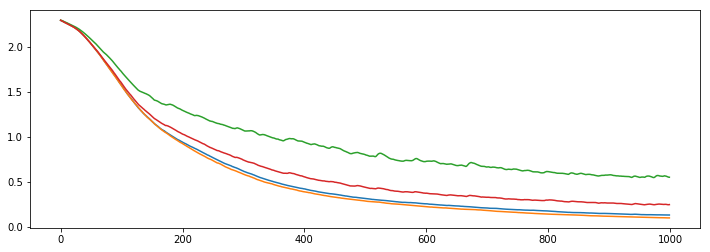

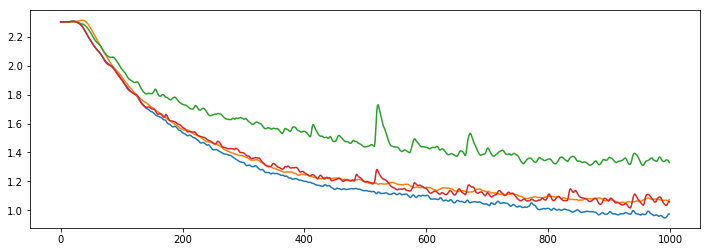

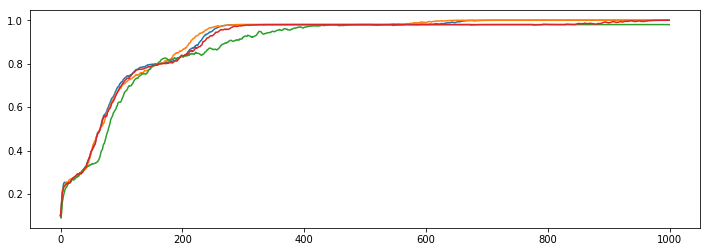

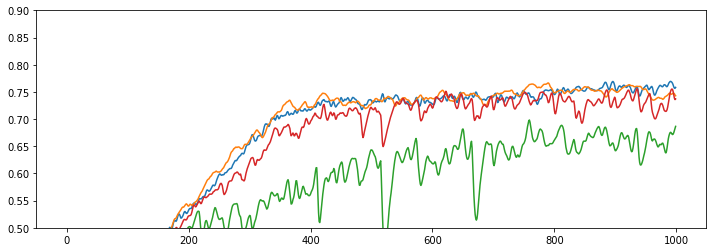

run 2
eta = 1

Epoch 1 of 1000 took 3.79s;
train loss:
data term: 2.33, constrain term: 0.00, full: 2.33
train acc: 10.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 2 of 1000 took 3.64s;
train loss:
data term: 2.33, constrain term: 0.00, full: 2.33
train acc: 6.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 3 of 1000 took 3.62s;
train loss:
data term: 2.32, constrain term: 0.00, full: 2.32
train acc: 14.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 4 of 1000 took 3.60s;
train loss:
data term: 2.31, constrain term: 0.00, full: 2.31
train acc: 12.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 5 of 1000 took 3.60s;
train loss:
data term: 2.30, constrain term: 0.00, full: 2.31
train acc: 16.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 6 of 1000 took 3.55s;
train loss:
data term: 2.30, constrain term: 0.00, full: 2.31
train acc: 18.00
test loss:
dat

Epoch 49 of 1000 took 3.60s;
train loss:
data term: 2.00, constrain term: 0.00, full: 2.01
train acc: 42.00
test loss:
data term: 2.16, constrain term: 0.00
test acc: 27.82

Epoch 50 of 1000 took 3.57s;
train loss:
data term: 1.99, constrain term: 0.00, full: 1.99
train acc: 48.00
test loss:
data term: 2.16, constrain term: 0.00
test acc: 28.07

Epoch 51 of 1000 took 3.55s;
train loss:
data term: 2.01, constrain term: 0.00, full: 2.01
train acc: 46.00
test loss:
data term: 2.15, constrain term: 0.00
test acc: 28.13

Epoch 52 of 1000 took 3.57s;
train loss:
data term: 1.99, constrain term: 0.00, full: 1.99
train acc: 48.00
test loss:
data term: 2.15, constrain term: 0.00
test acc: 28.63

Epoch 53 of 1000 took 3.56s;
train loss:
data term: 1.98, constrain term: 0.00, full: 1.98
train acc: 42.00
test loss:
data term: 2.15, constrain term: 0.00
test acc: 28.67

Epoch 54 of 1000 took 3.56s;
train loss:
data term: 1.97, constrain term: 0.01, full: 1.97
train acc: 48.00
test loss:
data term: 

Epoch 97 of 1000 took 3.56s;
train loss:
data term: 1.58, constrain term: 0.03, full: 1.60
train acc: 64.00
test loss:
data term: 1.96, constrain term: 0.00
test acc: 44.57

Epoch 98 of 1000 took 3.58s;
train loss:
data term: 1.57, constrain term: 0.00, full: 1.57
train acc: 70.00
test loss:
data term: 1.96, constrain term: 0.00
test acc: 44.85

Epoch 99 of 1000 took 3.61s;
train loss:
data term: 1.58, constrain term: 0.04, full: 1.62
train acc: 78.00
test loss:
data term: 1.95, constrain term: 0.00
test acc: 43.26

Epoch 100 of 1000 took 3.58s;
train loss:
data term: 1.56, constrain term: 0.04, full: 1.60
train acc: 76.00
test loss:
data term: 1.94, constrain term: 0.00
test acc: 41.14

Epoch 101 of 1000 took 3.57s;
train loss:
data term: 1.58, constrain term: 0.00, full: 1.58
train acc: 70.00
test loss:
data term: 1.92, constrain term: 0.00
test acc: 41.21

Epoch 102 of 1000 took 3.58s;
train loss:
data term: 1.54, constrain term: 0.00, full: 1.55
train acc: 78.00
test loss:
data ter

Epoch 144 of 1000 took 3.57s;
train loss:
data term: 1.26, constrain term: 0.02, full: 1.28
train acc: 82.00
test loss:
data term: 1.74, constrain term: 0.00
test acc: 49.44

Epoch 145 of 1000 took 3.56s;
train loss:
data term: 1.24, constrain term: 0.00, full: 1.24
train acc: 84.00
test loss:
data term: 1.74, constrain term: 0.00
test acc: 49.41

Epoch 146 of 1000 took 3.55s;
train loss:
data term: 1.23, constrain term: 0.03, full: 1.26
train acc: 82.00
test loss:
data term: 1.73, constrain term: 0.00
test acc: 50.95

Epoch 147 of 1000 took 3.55s;
train loss:
data term: 1.20, constrain term: 0.00, full: 1.20
train acc: 86.00
test loss:
data term: 1.73, constrain term: 0.00
test acc: 51.61

Epoch 148 of 1000 took 3.59s;
train loss:
data term: 1.23, constrain term: 0.04, full: 1.27
train acc: 84.00
test loss:
data term: 1.73, constrain term: 0.00
test acc: 52.63

Epoch 149 of 1000 took 3.55s;
train loss:
data term: 1.21, constrain term: 0.00, full: 1.21
train acc: 86.00
test loss:
data 

Epoch 191 of 1000 took 3.78s;
train loss:
data term: 1.00, constrain term: 0.03, full: 1.03
train acc: 86.00
test loss:
data term: 1.59, constrain term: 0.00
test acc: 56.69

Epoch 192 of 1000 took 3.77s;
train loss:
data term: 0.97, constrain term: 0.01, full: 0.98
train acc: 88.00
test loss:
data term: 1.60, constrain term: 0.00
test acc: 56.35

Epoch 193 of 1000 took 3.86s;
train loss:
data term: 0.98, constrain term: 0.02, full: 1.00
train acc: 88.00
test loss:
data term: 1.59, constrain term: 0.00
test acc: 56.67

Epoch 194 of 1000 took 3.56s;
train loss:
data term: 0.98, constrain term: 0.02, full: 1.00
train acc: 86.00
test loss:
data term: 1.57, constrain term: 0.00
test acc: 57.02

Epoch 195 of 1000 took 3.83s;
train loss:
data term: 0.97, constrain term: 0.01, full: 0.99
train acc: 86.00
test loss:
data term: 1.56, constrain term: 0.00
test acc: 57.77

Epoch 196 of 1000 took 3.60s;
train loss:
data term: 0.98, constrain term: 0.01, full: 0.98
train acc: 86.00
test loss:
data 

Epoch 238 of 1000 took 3.77s;
train loss:
data term: 0.79, constrain term: 0.00, full: 0.80
train acc: 92.00
test loss:
data term: 1.45, constrain term: 0.00
test acc: 60.66

Epoch 239 of 1000 took 3.92s;
train loss:
data term: 0.79, constrain term: 0.00, full: 0.79
train acc: 90.00
test loss:
data term: 1.46, constrain term: 0.00
test acc: 60.51

Epoch 240 of 1000 took 3.84s;
train loss:
data term: 0.78, constrain term: 0.02, full: 0.80
train acc: 92.00
test loss:
data term: 1.47, constrain term: 0.00
test acc: 59.94

Epoch 241 of 1000 took 3.67s;
train loss:
data term: 0.78, constrain term: 0.02, full: 0.80
train acc: 90.00
test loss:
data term: 1.47, constrain term: 0.00
test acc: 59.87

Epoch 242 of 1000 took 3.73s;
train loss:
data term: 0.77, constrain term: 0.00, full: 0.77
train acc: 90.00
test loss:
data term: 1.47, constrain term: 0.00
test acc: 60.46

Epoch 243 of 1000 took 3.76s;
train loss:
data term: 0.78, constrain term: 0.02, full: 0.80
train acc: 92.00
test loss:
data 

Epoch 285 of 1000 took 3.57s;
train loss:
data term: 0.65, constrain term: 0.03, full: 0.68
train acc: 94.00
test loss:
data term: 1.39, constrain term: 0.00
test acc: 62.75

Epoch 286 of 1000 took 3.55s;
train loss:
data term: 0.65, constrain term: 0.02, full: 0.67
train acc: 98.00
test loss:
data term: 1.39, constrain term: 0.00
test acc: 62.33

Epoch 287 of 1000 took 3.96s;
train loss:
data term: 0.63, constrain term: 0.01, full: 0.64
train acc: 96.00
test loss:
data term: 1.40, constrain term: 0.00
test acc: 62.59

Epoch 288 of 1000 took 3.71s;
train loss:
data term: 0.64, constrain term: 0.01, full: 0.65
train acc: 96.00
test loss:
data term: 1.40, constrain term: 0.00
test acc: 63.14

Epoch 289 of 1000 took 3.71s;
train loss:
data term: 0.64, constrain term: 0.02, full: 0.66
train acc: 96.00
test loss:
data term: 1.40, constrain term: 0.00
test acc: 63.79

Epoch 290 of 1000 took 4.07s;
train loss:
data term: 0.62, constrain term: 0.03, full: 0.65
train acc: 98.00
test loss:
data 

Epoch 332 of 1000 took 3.56s;
train loss:
data term: 0.51, constrain term: 0.03, full: 0.54
train acc: 100.00
test loss:
data term: 1.31, constrain term: 0.00
test acc: 67.28

Epoch 333 of 1000 took 3.56s;
train loss:
data term: 0.52, constrain term: 0.01, full: 0.53
train acc: 100.00
test loss:
data term: 1.31, constrain term: 0.00
test acc: 67.23

Epoch 334 of 1000 took 3.55s;
train loss:
data term: 0.51, constrain term: 0.01, full: 0.52
train acc: 100.00
test loss:
data term: 1.30, constrain term: 0.00
test acc: 68.20

Epoch 335 of 1000 took 3.56s;
train loss:
data term: 0.52, constrain term: 0.03, full: 0.55
train acc: 100.00
test loss:
data term: 1.30, constrain term: 0.00
test acc: 67.95

Epoch 336 of 1000 took 3.56s;
train loss:
data term: 0.52, constrain term: 0.03, full: 0.55
train acc: 98.00
test loss:
data term: 1.30, constrain term: 0.00
test acc: 67.77

Epoch 337 of 1000 took 3.56s;
train loss:
data term: 0.51, constrain term: 0.02, full: 0.53
train acc: 100.00
test loss:


Epoch 379 of 1000 took 3.54s;
train loss:
data term: 0.43, constrain term: 0.01, full: 0.45
train acc: 100.00
test loss:
data term: 1.23, constrain term: 0.00
test acc: 72.93

Epoch 380 of 1000 took 3.54s;
train loss:
data term: 0.44, constrain term: 0.04, full: 0.48
train acc: 100.00
test loss:
data term: 1.24, constrain term: 0.00
test acc: 73.20

Epoch 381 of 1000 took 3.54s;
train loss:
data term: 0.43, constrain term: 0.01, full: 0.45
train acc: 100.00
test loss:
data term: 1.24, constrain term: 0.00
test acc: 74.38

Epoch 382 of 1000 took 3.56s;
train loss:
data term: 0.43, constrain term: 0.00, full: 0.43
train acc: 100.00
test loss:
data term: 1.24, constrain term: 0.00
test acc: 73.72

Epoch 383 of 1000 took 3.54s;
train loss:
data term: 0.43, constrain term: 0.02, full: 0.45
train acc: 100.00
test loss:
data term: 1.24, constrain term: 0.00
test acc: 73.36

Epoch 384 of 1000 took 3.55s;
train loss:
data term: 0.43, constrain term: 0.01, full: 0.45
train acc: 100.00
test loss:

Epoch 426 of 1000 took 3.54s;
train loss:
data term: 0.36, constrain term: 0.03, full: 0.38
train acc: 100.00
test loss:
data term: 1.20, constrain term: 0.00
test acc: 73.82

Epoch 427 of 1000 took 3.54s;
train loss:
data term: 0.35, constrain term: 0.01, full: 0.36
train acc: 100.00
test loss:
data term: 1.18, constrain term: 0.00
test acc: 73.82

Epoch 428 of 1000 took 3.55s;
train loss:
data term: 0.36, constrain term: 0.02, full: 0.37
train acc: 100.00
test loss:
data term: 1.18, constrain term: 0.00
test acc: 74.14

Epoch 429 of 1000 took 3.54s;
train loss:
data term: 0.36, constrain term: 0.02, full: 0.38
train acc: 100.00
test loss:
data term: 1.18, constrain term: 0.00
test acc: 73.60

Epoch 430 of 1000 took 3.54s;
train loss:
data term: 0.35, constrain term: 0.02, full: 0.37
train acc: 100.00
test loss:
data term: 1.18, constrain term: 0.00
test acc: 73.49

Epoch 431 of 1000 took 3.54s;
train loss:
data term: 0.35, constrain term: 0.01, full: 0.37
train acc: 100.00
test loss:

Epoch 473 of 1000 took 3.63s;
train loss:
data term: 0.31, constrain term: 0.03, full: 0.33
train acc: 100.00
test loss:
data term: 1.16, constrain term: 0.00
test acc: 73.68

Epoch 474 of 1000 took 3.61s;
train loss:
data term: 0.30, constrain term: 0.03, full: 0.33
train acc: 100.00
test loss:
data term: 1.15, constrain term: 0.00
test acc: 74.32

Epoch 475 of 1000 took 3.54s;
train loss:
data term: 0.31, constrain term: 0.03, full: 0.34
train acc: 100.00
test loss:
data term: 1.14, constrain term: 0.00
test acc: 74.99

Epoch 476 of 1000 took 3.54s;
train loss:
data term: 0.30, constrain term: 0.02, full: 0.32
train acc: 100.00
test loss:
data term: 1.14, constrain term: 0.00
test acc: 74.44

Epoch 477 of 1000 took 3.54s;
train loss:
data term: 0.30, constrain term: 0.03, full: 0.33
train acc: 100.00
test loss:
data term: 1.13, constrain term: 0.00
test acc: 74.82

Epoch 478 of 1000 took 3.62s;
train loss:
data term: 0.30, constrain term: 0.03, full: 0.33
train acc: 100.00
test loss:

Epoch 520 of 1000 took 3.55s;
train loss:
data term: 0.26, constrain term: 0.02, full: 0.28
train acc: 100.00
test loss:
data term: 1.10, constrain term: 0.00
test acc: 75.54

Epoch 521 of 1000 took 3.56s;
train loss:
data term: 0.26, constrain term: 0.02, full: 0.29
train acc: 100.00
test loss:
data term: 1.09, constrain term: 0.00
test acc: 75.59

Epoch 522 of 1000 took 3.56s;
train loss:
data term: 0.26, constrain term: 0.02, full: 0.28
train acc: 100.00
test loss:
data term: 1.10, constrain term: 0.00
test acc: 75.33

Epoch 523 of 1000 took 3.55s;
train loss:
data term: 0.26, constrain term: 0.02, full: 0.29
train acc: 100.00
test loss:
data term: 1.09, constrain term: 0.00
test acc: 75.91

Epoch 524 of 1000 took 3.56s;
train loss:
data term: 0.26, constrain term: 0.02, full: 0.27
train acc: 100.00
test loss:
data term: 1.10, constrain term: 0.00
test acc: 75.16

Epoch 525 of 1000 took 3.56s;
train loss:
data term: 0.26, constrain term: 0.02, full: 0.28
train acc: 100.00
test loss:

Epoch 567 of 1000 took 3.56s;
train loss:
data term: 0.23, constrain term: 0.02, full: 0.25
train acc: 100.00
test loss:
data term: 1.06, constrain term: 0.00
test acc: 76.80

Epoch 568 of 1000 took 3.59s;
train loss:
data term: 0.23, constrain term: 0.02, full: 0.25
train acc: 100.00
test loss:
data term: 1.04, constrain term: 0.00
test acc: 77.36

Epoch 569 of 1000 took 3.55s;
train loss:
data term: 0.23, constrain term: 0.02, full: 0.25
train acc: 100.00
test loss:
data term: 1.05, constrain term: 0.00
test acc: 76.94

Epoch 570 of 1000 took 3.56s;
train loss:
data term: 0.23, constrain term: 0.02, full: 0.25
train acc: 100.00
test loss:
data term: 1.07, constrain term: 0.00
test acc: 75.61

Epoch 571 of 1000 took 3.55s;
train loss:
data term: 0.23, constrain term: 0.02, full: 0.24
train acc: 100.00
test loss:
data term: 1.08, constrain term: 0.00
test acc: 74.61

Epoch 572 of 1000 took 3.56s;
train loss:
data term: 0.23, constrain term: 0.03, full: 0.26
train acc: 100.00
test loss:

Epoch 614 of 1000 took 3.74s;
train loss:
data term: 0.21, constrain term: 0.01, full: 0.22
train acc: 100.00
test loss:
data term: 1.08, constrain term: 0.00
test acc: 74.50

Epoch 615 of 1000 took 3.58s;
train loss:
data term: 0.20, constrain term: 0.02, full: 0.22
train acc: 100.00
test loss:
data term: 1.08, constrain term: 0.00
test acc: 74.54

Epoch 616 of 1000 took 3.55s;
train loss:
data term: 0.20, constrain term: 0.02, full: 0.22
train acc: 100.00
test loss:
data term: 1.07, constrain term: 0.00
test acc: 74.73

Epoch 617 of 1000 took 3.55s;
train loss:
data term: 0.21, constrain term: 0.02, full: 0.23
train acc: 100.00
test loss:
data term: 1.07, constrain term: 0.00
test acc: 75.09

Epoch 618 of 1000 took 3.55s;
train loss:
data term: 0.20, constrain term: 0.02, full: 0.22
train acc: 100.00
test loss:
data term: 1.06, constrain term: 0.00
test acc: 75.97

Epoch 619 of 1000 took 3.54s;
train loss:
data term: 0.20, constrain term: 0.02, full: 0.22
train acc: 100.00
test loss:

Epoch 661 of 1000 took 3.55s;
train loss:
data term: 0.18, constrain term: 0.02, full: 0.20
train acc: 100.00
test loss:
data term: 1.04, constrain term: 0.00
test acc: 75.02

Epoch 662 of 1000 took 3.54s;
train loss:
data term: 0.18, constrain term: 0.02, full: 0.20
train acc: 100.00
test loss:
data term: 1.03, constrain term: 0.00
test acc: 75.91

Epoch 663 of 1000 took 3.55s;
train loss:
data term: 0.18, constrain term: 0.03, full: 0.21
train acc: 100.00
test loss:
data term: 1.05, constrain term: 0.00
test acc: 74.89

Epoch 664 of 1000 took 3.54s;
train loss:
data term: 0.19, constrain term: 0.03, full: 0.22
train acc: 100.00
test loss:
data term: 1.06, constrain term: 0.00
test acc: 74.61

Epoch 665 of 1000 took 3.55s;
train loss:
data term: 0.18, constrain term: 0.02, full: 0.20
train acc: 100.00
test loss:
data term: 1.04, constrain term: 0.00
test acc: 75.69

Epoch 666 of 1000 took 3.54s;
train loss:
data term: 0.18, constrain term: 0.02, full: 0.20
train acc: 100.00
test loss:

Epoch 708 of 1000 took 3.55s;
train loss:
data term: 0.16, constrain term: 0.01, full: 0.17
train acc: 100.00
test loss:
data term: 1.00, constrain term: 0.00
test acc: 76.93

Epoch 709 of 1000 took 3.54s;
train loss:
data term: 0.17, constrain term: 0.02, full: 0.19
train acc: 100.00
test loss:
data term: 1.01, constrain term: 0.00
test acc: 76.74

Epoch 710 of 1000 took 3.54s;
train loss:
data term: 0.16, constrain term: 0.03, full: 0.20
train acc: 100.00
test loss:
data term: 1.02, constrain term: 0.00
test acc: 76.23

Epoch 711 of 1000 took 3.55s;
train loss:
data term: 0.16, constrain term: 0.02, full: 0.18
train acc: 100.00
test loss:
data term: 1.02, constrain term: 0.00
test acc: 76.12

Epoch 712 of 1000 took 3.54s;
train loss:
data term: 0.16, constrain term: 0.03, full: 0.20
train acc: 100.00
test loss:
data term: 1.03, constrain term: 0.00
test acc: 75.34

Epoch 713 of 1000 took 3.54s;
train loss:
data term: 0.17, constrain term: 0.01, full: 0.17
train acc: 100.00
test loss:

Epoch 755 of 1000 took 3.54s;
train loss:
data term: 0.16, constrain term: 0.02, full: 0.18
train acc: 100.00
test loss:
data term: 0.99, constrain term: 0.00
test acc: 76.60

Epoch 756 of 1000 took 3.54s;
train loss:
data term: 0.16, constrain term: 0.02, full: 0.17
train acc: 100.00
test loss:
data term: 1.01, constrain term: 0.00
test acc: 75.41

Epoch 757 of 1000 took 3.54s;
train loss:
data term: 0.16, constrain term: 0.02, full: 0.18
train acc: 100.00
test loss:
data term: 1.02, constrain term: 0.00
test acc: 74.71

Epoch 758 of 1000 took 3.56s;
train loss:
data term: 0.16, constrain term: 0.05, full: 0.21
train acc: 100.00
test loss:
data term: 1.00, constrain term: 0.00
test acc: 75.96

Epoch 759 of 1000 took 3.54s;
train loss:
data term: 0.16, constrain term: 0.01, full: 0.17
train acc: 100.00
test loss:
data term: 0.98, constrain term: 0.00
test acc: 77.80

Epoch 760 of 1000 took 3.54s;
train loss:
data term: 0.15, constrain term: 0.01, full: 0.17
train acc: 100.00
test loss:

Epoch 802 of 1000 took 3.55s;
train loss:
data term: 0.14, constrain term: 0.02, full: 0.16
train acc: 100.00
test loss:
data term: 1.00, constrain term: 0.00
test acc: 76.18

Epoch 803 of 1000 took 3.54s;
train loss:
data term: 0.14, constrain term: 0.01, full: 0.16
train acc: 100.00
test loss:
data term: 1.00, constrain term: 0.00
test acc: 76.48

Epoch 804 of 1000 took 3.54s;
train loss:
data term: 0.14, constrain term: 0.03, full: 0.18
train acc: 100.00
test loss:
data term: 0.99, constrain term: 0.00
test acc: 76.79

Epoch 805 of 1000 took 3.54s;
train loss:
data term: 0.14, constrain term: 0.02, full: 0.16
train acc: 100.00
test loss:
data term: 0.97, constrain term: 0.00
test acc: 77.88

Epoch 806 of 1000 took 3.54s;
train loss:
data term: 0.15, constrain term: 0.04, full: 0.19
train acc: 100.00
test loss:
data term: 0.97, constrain term: 0.00
test acc: 77.32

Epoch 807 of 1000 took 3.54s;
train loss:
data term: 0.14, constrain term: 0.03, full: 0.17
train acc: 100.00
test loss:

Epoch 849 of 1000 took 3.54s;
train loss:
data term: 0.14, constrain term: 0.01, full: 0.15
train acc: 100.00
test loss:
data term: 0.96, constrain term: 0.00
test acc: 77.04

Epoch 850 of 1000 took 3.54s;
train loss:
data term: 0.13, constrain term: 0.02, full: 0.15
train acc: 100.00
test loss:
data term: 0.94, constrain term: 0.00
test acc: 77.50

Epoch 851 of 1000 took 3.54s;
train loss:
data term: 0.13, constrain term: 0.02, full: 0.16
train acc: 100.00
test loss:
data term: 0.94, constrain term: 0.00
test acc: 77.62

Epoch 852 of 1000 took 3.53s;
train loss:
data term: 0.14, constrain term: 0.02, full: 0.16
train acc: 100.00
test loss:
data term: 0.95, constrain term: 0.00
test acc: 76.98

Epoch 853 of 1000 took 3.54s;
train loss:
data term: 0.13, constrain term: 0.01, full: 0.15
train acc: 100.00
test loss:
data term: 0.96, constrain term: 0.00
test acc: 76.29

Epoch 854 of 1000 took 3.54s;
train loss:
data term: 0.13, constrain term: 0.03, full: 0.16
train acc: 100.00
test loss:

Epoch 896 of 1000 took 3.55s;
train loss:
data term: 0.13, constrain term: 0.02, full: 0.14
train acc: 100.00
test loss:
data term: 0.96, constrain term: 0.00
test acc: 76.49

Epoch 897 of 1000 took 3.54s;
train loss:
data term: 0.13, constrain term: 0.01, full: 0.14
train acc: 100.00
test loss:
data term: 0.96, constrain term: 0.00
test acc: 76.89

Epoch 898 of 1000 took 3.54s;
train loss:
data term: 0.13, constrain term: 0.02, full: 0.15
train acc: 100.00
test loss:
data term: 0.96, constrain term: 0.00
test acc: 76.62

Epoch 899 of 1000 took 3.54s;
train loss:
data term: 0.12, constrain term: 0.02, full: 0.15
train acc: 100.00
test loss:
data term: 0.98, constrain term: 0.00
test acc: 75.77

Epoch 900 of 1000 took 3.54s;
train loss:
data term: 0.12, constrain term: 0.03, full: 0.15
train acc: 100.00
test loss:
data term: 0.98, constrain term: 0.00
test acc: 75.69

Epoch 901 of 1000 took 3.55s;
train loss:
data term: 0.12, constrain term: 0.02, full: 0.14
train acc: 100.00
test loss:

Epoch 943 of 1000 took 3.54s;
train loss:
data term: 0.12, constrain term: 0.04, full: 0.16
train acc: 100.00
test loss:
data term: 0.91, constrain term: 0.00
test acc: 78.55

Epoch 944 of 1000 took 3.54s;
train loss:
data term: 0.12, constrain term: 0.01, full: 0.13
train acc: 100.00
test loss:
data term: 0.91, constrain term: 0.00
test acc: 78.89

Epoch 945 of 1000 took 3.54s;
train loss:
data term: 0.12, constrain term: 0.01, full: 0.13
train acc: 100.00
test loss:
data term: 0.92, constrain term: 0.00
test acc: 78.14

Epoch 946 of 1000 took 3.54s;
train loss:
data term: 0.11, constrain term: 0.04, full: 0.15
train acc: 100.00
test loss:
data term: 0.93, constrain term: 0.00
test acc: 77.52

Epoch 947 of 1000 took 3.54s;
train loss:
data term: 0.12, constrain term: 0.02, full: 0.14
train acc: 100.00
test loss:
data term: 0.93, constrain term: 0.00
test acc: 77.04

Epoch 948 of 1000 took 3.54s;
train loss:
data term: 0.12, constrain term: 0.01, full: 0.13
train acc: 100.00
test loss:

Epoch 990 of 1000 took 3.55s;
train loss:
data term: 0.11, constrain term: 0.02, full: 0.13
train acc: 100.00
test loss:
data term: 0.91, constrain term: 0.00
test acc: 78.71

Epoch 991 of 1000 took 3.54s;
train loss:
data term: 0.11, constrain term: 0.01, full: 0.13
train acc: 100.00
test loss:
data term: 0.90, constrain term: 0.00
test acc: 79.31

Epoch 992 of 1000 took 3.54s;
train loss:
data term: 0.11, constrain term: 0.02, full: 0.13
train acc: 100.00
test loss:
data term: 0.90, constrain term: 0.00
test acc: 79.37

Epoch 993 of 1000 took 3.55s;
train loss:
data term: 0.11, constrain term: 0.01, full: 0.12
train acc: 100.00
test loss:
data term: 0.91, constrain term: 0.00
test acc: 78.88

Epoch 994 of 1000 took 3.56s;
train loss:
data term: 0.11, constrain term: 0.02, full: 0.13
train acc: 100.00
test loss:
data term: 0.92, constrain term: 0.00
test acc: 78.51

Epoch 995 of 1000 took 3.54s;
train loss:
data term: 0.11, constrain term: 0.02, full: 0.12
train acc: 100.00
test loss:

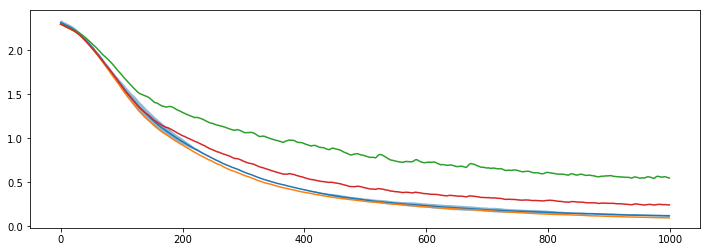

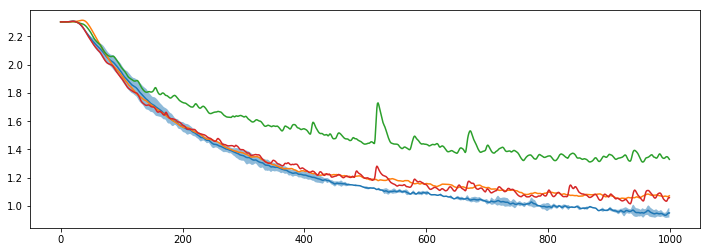

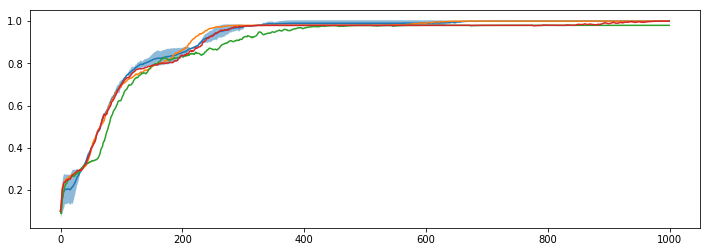

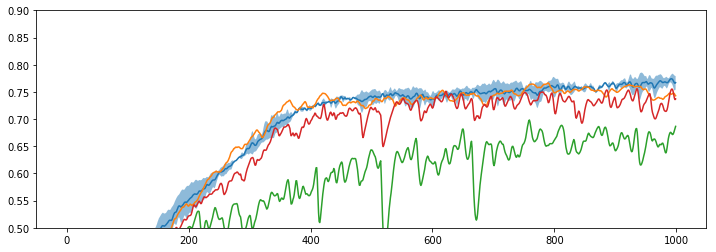

eta = 0

Epoch 1 of 1000 took 3.25s;
train loss:
data term: 2.33, constrain term: 0.00, full: 2.33
train acc: 10.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 2 of 1000 took 3.14s;
train loss:
data term: 2.33, constrain term: 0.00, full: 2.33
train acc: 16.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 3 of 1000 took 3.15s;
train loss:
data term: 2.32, constrain term: 0.00, full: 2.32
train acc: 12.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 4 of 1000 took 3.14s;
train loss:
data term: 2.31, constrain term: 0.00, full: 2.31
train acc: 18.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 5 of 1000 took 3.14s;
train loss:
data term: 2.31, constrain term: 0.00, full: 2.31
train acc: 8.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 6 of 1000 took 3.14s;
train loss:
data term: 2.30, constrain term: 0.00, full: 2.30
train acc: 14.00
test loss:
data term

Epoch 49 of 1000 took 3.14s;
train loss:
data term: 2.00, constrain term: 0.00, full: 2.00
train acc: 52.00
test loss:
data term: 2.25, constrain term: 0.00
test acc: 19.14

Epoch 50 of 1000 took 3.14s;
train loss:
data term: 2.00, constrain term: 0.00, full: 2.00
train acc: 42.00
test loss:
data term: 2.24, constrain term: 0.00
test acc: 20.49

Epoch 51 of 1000 took 3.14s;
train loss:
data term: 1.99, constrain term: 0.00, full: 1.99
train acc: 46.00
test loss:
data term: 2.23, constrain term: 0.00
test acc: 21.57

Epoch 52 of 1000 took 3.14s;
train loss:
data term: 1.97, constrain term: 0.00, full: 1.97
train acc: 46.00
test loss:
data term: 2.22, constrain term: 0.00
test acc: 22.10

Epoch 53 of 1000 took 3.14s;
train loss:
data term: 1.95, constrain term: 0.00, full: 1.95
train acc: 50.00
test loss:
data term: 2.22, constrain term: 0.00
test acc: 22.88

Epoch 54 of 1000 took 3.14s;
train loss:
data term: 1.96, constrain term: 0.00, full: 1.96
train acc: 42.00
test loss:
data term: 

Epoch 97 of 1000 took 3.18s;
train loss:
data term: 1.57, constrain term: 0.00, full: 1.57
train acc: 74.00
test loss:
data term: 2.05, constrain term: 0.00
test acc: 25.07

Epoch 98 of 1000 took 3.17s;
train loss:
data term: 1.56, constrain term: 0.00, full: 1.56
train acc: 72.00
test loss:
data term: 2.03, constrain term: 0.00
test acc: 27.78

Epoch 99 of 1000 took 3.17s;
train loss:
data term: 1.56, constrain term: 0.00, full: 1.56
train acc: 74.00
test loss:
data term: 2.02, constrain term: 0.00
test acc: 28.83

Epoch 100 of 1000 took 3.17s;
train loss:
data term: 1.55, constrain term: 0.00, full: 1.55
train acc: 74.00
test loss:
data term: 2.01, constrain term: 0.00
test acc: 29.71

Epoch 101 of 1000 took 3.15s;
train loss:
data term: 1.55, constrain term: 0.00, full: 1.55
train acc: 66.00
test loss:
data term: 1.99, constrain term: 0.00
test acc: 32.06

Epoch 102 of 1000 took 3.14s;
train loss:
data term: 1.54, constrain term: 0.00, full: 1.54
train acc: 70.00
test loss:
data ter

Epoch 144 of 1000 took 3.14s;
train loss:
data term: 1.23, constrain term: 0.00, full: 1.23
train acc: 80.00
test loss:
data term: 1.80, constrain term: 0.00
test acc: 48.20

Epoch 145 of 1000 took 3.14s;
train loss:
data term: 1.25, constrain term: 0.00, full: 1.25
train acc: 80.00
test loss:
data term: 1.81, constrain term: 0.00
test acc: 47.44

Epoch 146 of 1000 took 3.14s;
train loss:
data term: 1.21, constrain term: 0.00, full: 1.21
train acc: 86.00
test loss:
data term: 1.81, constrain term: 0.00
test acc: 48.23

Epoch 147 of 1000 took 3.14s;
train loss:
data term: 1.22, constrain term: 0.00, full: 1.22
train acc: 80.00
test loss:
data term: 1.81, constrain term: 0.00
test acc: 48.03

Epoch 148 of 1000 took 3.14s;
train loss:
data term: 1.23, constrain term: 0.00, full: 1.23
train acc: 82.00
test loss:
data term: 1.80, constrain term: 0.00
test acc: 48.49

Epoch 149 of 1000 took 3.15s;
train loss:
data term: 1.21, constrain term: 0.00, full: 1.21
train acc: 82.00
test loss:
data 

Epoch 191 of 1000 took 3.14s;
train loss:
data term: 0.98, constrain term: 0.00, full: 0.98
train acc: 86.00
test loss:
data term: 1.68, constrain term: 0.00
test acc: 50.78

Epoch 192 of 1000 took 3.15s;
train loss:
data term: 0.97, constrain term: 0.00, full: 0.97
train acc: 86.00
test loss:
data term: 1.68, constrain term: 0.00
test acc: 51.46

Epoch 193 of 1000 took 3.17s;
train loss:
data term: 0.98, constrain term: 0.00, full: 0.98
train acc: 86.00
test loss:
data term: 1.68, constrain term: 0.00
test acc: 51.75

Epoch 194 of 1000 took 3.15s;
train loss:
data term: 0.99, constrain term: 0.00, full: 0.99
train acc: 86.00
test loss:
data term: 1.68, constrain term: 0.00
test acc: 51.94

Epoch 195 of 1000 took 3.14s;
train loss:
data term: 0.97, constrain term: 0.00, full: 0.97
train acc: 86.00
test loss:
data term: 1.67, constrain term: 0.00
test acc: 51.81

Epoch 196 of 1000 took 3.14s;
train loss:
data term: 0.96, constrain term: 0.00, full: 0.96
train acc: 86.00
test loss:
data 

Epoch 238 of 1000 took 3.14s;
train loss:
data term: 0.78, constrain term: 0.00, full: 0.78
train acc: 88.00
test loss:
data term: 1.54, constrain term: 0.00
test acc: 58.03

Epoch 239 of 1000 took 3.15s;
train loss:
data term: 0.78, constrain term: 0.00, full: 0.78
train acc: 92.00
test loss:
data term: 1.54, constrain term: 0.00
test acc: 57.98

Epoch 240 of 1000 took 3.14s;
train loss:
data term: 0.78, constrain term: 0.00, full: 0.78
train acc: 90.00
test loss:
data term: 1.53, constrain term: 0.00
test acc: 58.13

Epoch 241 of 1000 took 3.14s;
train loss:
data term: 0.77, constrain term: 0.00, full: 0.77
train acc: 90.00
test loss:
data term: 1.54, constrain term: 0.00
test acc: 58.45

Epoch 242 of 1000 took 3.14s;
train loss:
data term: 0.80, constrain term: 0.00, full: 0.80
train acc: 90.00
test loss:
data term: 1.53, constrain term: 0.00
test acc: 59.12

Epoch 243 of 1000 took 3.14s;
train loss:
data term: 0.77, constrain term: 0.00, full: 0.77
train acc: 88.00
test loss:
data 

Epoch 285 of 1000 took 3.15s;
train loss:
data term: 0.62, constrain term: 0.00, full: 0.62
train acc: 94.00
test loss:
data term: 1.46, constrain term: 0.00
test acc: 62.16

Epoch 286 of 1000 took 3.15s;
train loss:
data term: 0.63, constrain term: 0.00, full: 0.63
train acc: 96.00
test loss:
data term: 1.45, constrain term: 0.00
test acc: 61.54

Epoch 287 of 1000 took 3.14s;
train loss:
data term: 0.63, constrain term: 0.00, full: 0.63
train acc: 96.00
test loss:
data term: 1.45, constrain term: 0.00
test acc: 61.41

Epoch 288 of 1000 took 3.15s;
train loss:
data term: 0.63, constrain term: 0.00, full: 0.63
train acc: 96.00
test loss:
data term: 1.45, constrain term: 0.00
test acc: 61.28

Epoch 289 of 1000 took 3.15s;
train loss:
data term: 0.62, constrain term: 0.00, full: 0.62
train acc: 96.00
test loss:
data term: 1.44, constrain term: 0.00
test acc: 61.91

Epoch 290 of 1000 took 3.15s;
train loss:
data term: 0.62, constrain term: 0.00, full: 0.62
train acc: 94.00
test loss:
data 

Epoch 332 of 1000 took 3.14s;
train loss:
data term: 0.51, constrain term: 0.00, full: 0.51
train acc: 98.00
test loss:
data term: 1.43, constrain term: 0.00
test acc: 62.51

Epoch 333 of 1000 took 3.15s;
train loss:
data term: 0.52, constrain term: 0.00, full: 0.52
train acc: 100.00
test loss:
data term: 1.41, constrain term: 0.00
test acc: 63.22

Epoch 334 of 1000 took 3.14s;
train loss:
data term: 0.51, constrain term: 0.00, full: 0.51
train acc: 100.00
test loss:
data term: 1.41, constrain term: 0.00
test acc: 63.82

Epoch 335 of 1000 took 3.14s;
train loss:
data term: 0.52, constrain term: 0.00, full: 0.52
train acc: 98.00
test loss:
data term: 1.41, constrain term: 0.00
test acc: 63.26

Epoch 336 of 1000 took 3.14s;
train loss:
data term: 0.50, constrain term: 0.00, full: 0.50
train acc: 100.00
test loss:
data term: 1.41, constrain term: 0.00
test acc: 62.87

Epoch 337 of 1000 took 3.14s;
train loss:
data term: 0.51, constrain term: 0.00, full: 0.51
train acc: 96.00
test loss:
da

Epoch 379 of 1000 took 3.14s;
train loss:
data term: 0.42, constrain term: 0.00, full: 0.42
train acc: 100.00
test loss:
data term: 1.33, constrain term: 0.00
test acc: 69.22

Epoch 380 of 1000 took 3.14s;
train loss:
data term: 0.42, constrain term: 0.00, full: 0.42
train acc: 100.00
test loss:
data term: 1.33, constrain term: 0.00
test acc: 69.20

Epoch 381 of 1000 took 3.15s;
train loss:
data term: 0.42, constrain term: 0.00, full: 0.42
train acc: 100.00
test loss:
data term: 1.33, constrain term: 0.00
test acc: 69.03

Epoch 382 of 1000 took 3.14s;
train loss:
data term: 0.43, constrain term: 0.00, full: 0.43
train acc: 100.00
test loss:
data term: 1.33, constrain term: 0.00
test acc: 68.83

Epoch 383 of 1000 took 3.15s;
train loss:
data term: 0.41, constrain term: 0.00, full: 0.41
train acc: 100.00
test loss:
data term: 1.33, constrain term: 0.00
test acc: 69.01

Epoch 384 of 1000 took 3.14s;
train loss:
data term: 0.43, constrain term: 0.00, full: 0.43
train acc: 100.00
test loss:

Epoch 426 of 1000 took 3.17s;
train loss:
data term: 0.35, constrain term: 0.00, full: 0.35
train acc: 100.00
test loss:
data term: 1.31, constrain term: 0.00
test acc: 71.48

Epoch 427 of 1000 took 3.14s;
train loss:
data term: 0.35, constrain term: 0.00, full: 0.35
train acc: 100.00
test loss:
data term: 1.31, constrain term: 0.00
test acc: 72.03

Epoch 428 of 1000 took 3.14s;
train loss:
data term: 0.34, constrain term: 0.00, full: 0.34
train acc: 100.00
test loss:
data term: 1.31, constrain term: 0.00
test acc: 72.55

Epoch 429 of 1000 took 3.15s;
train loss:
data term: 0.34, constrain term: 0.00, full: 0.34
train acc: 100.00
test loss:
data term: 1.30, constrain term: 0.00
test acc: 71.88

Epoch 430 of 1000 took 3.14s;
train loss:
data term: 0.34, constrain term: 0.00, full: 0.34
train acc: 100.00
test loss:
data term: 1.30, constrain term: 0.00
test acc: 72.20

Epoch 431 of 1000 took 3.15s;
train loss:
data term: 0.35, constrain term: 0.00, full: 0.35
train acc: 100.00
test loss:

Epoch 473 of 1000 took 3.14s;
train loss:
data term: 0.29, constrain term: 0.00, full: 0.29
train acc: 100.00
test loss:
data term: 1.26, constrain term: 0.00
test acc: 72.60

Epoch 474 of 1000 took 3.14s;
train loss:
data term: 0.29, constrain term: 0.00, full: 0.29
train acc: 100.00
test loss:
data term: 1.26, constrain term: 0.00
test acc: 72.66

Epoch 475 of 1000 took 3.14s;
train loss:
data term: 0.28, constrain term: 0.00, full: 0.28
train acc: 100.00
test loss:
data term: 1.26, constrain term: 0.00
test acc: 72.96

Epoch 476 of 1000 took 3.14s;
train loss:
data term: 0.28, constrain term: 0.00, full: 0.28
train acc: 100.00
test loss:
data term: 1.26, constrain term: 0.00
test acc: 72.52

Epoch 477 of 1000 took 3.14s;
train loss:
data term: 0.28, constrain term: 0.00, full: 0.28
train acc: 100.00
test loss:
data term: 1.26, constrain term: 0.00
test acc: 72.51

Epoch 478 of 1000 took 3.14s;
train loss:
data term: 0.28, constrain term: 0.00, full: 0.28
train acc: 100.00
test loss:

Epoch 520 of 1000 took 3.14s;
train loss:
data term: 0.24, constrain term: 0.00, full: 0.24
train acc: 100.00
test loss:
data term: 1.25, constrain term: 0.00
test acc: 72.29

Epoch 521 of 1000 took 3.14s;
train loss:
data term: 0.24, constrain term: 0.00, full: 0.24
train acc: 100.00
test loss:
data term: 1.24, constrain term: 0.00
test acc: 72.39

Epoch 522 of 1000 took 3.14s;
train loss:
data term: 0.25, constrain term: 0.00, full: 0.25
train acc: 100.00
test loss:
data term: 1.24, constrain term: 0.00
test acc: 71.82

Epoch 523 of 1000 took 3.14s;
train loss:
data term: 0.25, constrain term: 0.00, full: 0.25
train acc: 100.00
test loss:
data term: 1.24, constrain term: 0.00
test acc: 72.21

Epoch 524 of 1000 took 3.15s;
train loss:
data term: 0.24, constrain term: 0.00, full: 0.24
train acc: 100.00
test loss:
data term: 1.24, constrain term: 0.00
test acc: 71.78

Epoch 525 of 1000 took 3.14s;
train loss:
data term: 0.24, constrain term: 0.00, full: 0.24
train acc: 100.00
test loss:

Epoch 567 of 1000 took 3.15s;
train loss:
data term: 0.21, constrain term: 0.00, full: 0.21
train acc: 100.00
test loss:
data term: 1.22, constrain term: 0.00
test acc: 73.76

Epoch 568 of 1000 took 3.15s;
train loss:
data term: 0.21, constrain term: 0.00, full: 0.21
train acc: 100.00
test loss:
data term: 1.22, constrain term: 0.00
test acc: 73.64

Epoch 569 of 1000 took 3.15s;
train loss:
data term: 0.21, constrain term: 0.00, full: 0.21
train acc: 100.00
test loss:
data term: 1.22, constrain term: 0.00
test acc: 72.98

Epoch 570 of 1000 took 3.16s;
train loss:
data term: 0.21, constrain term: 0.00, full: 0.21
train acc: 100.00
test loss:
data term: 1.22, constrain term: 0.00
test acc: 73.39

Epoch 571 of 1000 took 3.16s;
train loss:
data term: 0.21, constrain term: 0.00, full: 0.21
train acc: 100.00
test loss:
data term: 1.22, constrain term: 0.00
test acc: 72.92

Epoch 572 of 1000 took 3.17s;
train loss:
data term: 0.20, constrain term: 0.00, full: 0.20
train acc: 100.00
test loss:

Epoch 614 of 1000 took 3.14s;
train loss:
data term: 0.18, constrain term: 0.00, full: 0.18
train acc: 100.00
test loss:
data term: 1.20, constrain term: 0.00
test acc: 72.54

Epoch 615 of 1000 took 3.14s;
train loss:
data term: 0.18, constrain term: 0.00, full: 0.18
train acc: 100.00
test loss:
data term: 1.21, constrain term: 0.00
test acc: 71.83

Epoch 616 of 1000 took 3.17s;
train loss:
data term: 0.18, constrain term: 0.00, full: 0.18
train acc: 100.00
test loss:
data term: 1.22, constrain term: 0.00
test acc: 71.53

Epoch 617 of 1000 took 3.15s;
train loss:
data term: 0.18, constrain term: 0.00, full: 0.18
train acc: 100.00
test loss:
data term: 1.22, constrain term: 0.00
test acc: 71.86

Epoch 618 of 1000 took 3.14s;
train loss:
data term: 0.18, constrain term: 0.00, full: 0.18
train acc: 100.00
test loss:
data term: 1.21, constrain term: 0.00
test acc: 72.25

Epoch 619 of 1000 took 3.15s;
train loss:
data term: 0.19, constrain term: 0.00, full: 0.19
train acc: 100.00
test loss:

Epoch 661 of 1000 took 3.14s;
train loss:
data term: 0.17, constrain term: 0.00, full: 0.17
train acc: 100.00
test loss:
data term: 1.20, constrain term: 0.00
test acc: 72.60

Epoch 662 of 1000 took 3.14s;
train loss:
data term: 0.16, constrain term: 0.00, full: 0.16
train acc: 100.00
test loss:
data term: 1.21, constrain term: 0.00
test acc: 71.87

Epoch 663 of 1000 took 3.14s;
train loss:
data term: 0.16, constrain term: 0.00, full: 0.16
train acc: 100.00
test loss:
data term: 1.21, constrain term: 0.00
test acc: 71.55

Epoch 664 of 1000 took 3.15s;
train loss:
data term: 0.16, constrain term: 0.00, full: 0.16
train acc: 100.00
test loss:
data term: 1.20, constrain term: 0.00
test acc: 71.48

Epoch 665 of 1000 took 3.15s;
train loss:
data term: 0.17, constrain term: 0.00, full: 0.17
train acc: 100.00
test loss:
data term: 1.19, constrain term: 0.00
test acc: 71.92

Epoch 666 of 1000 took 3.14s;
train loss:
data term: 0.16, constrain term: 0.00, full: 0.16
train acc: 100.00
test loss:

Epoch 708 of 1000 took 3.15s;
train loss:
data term: 0.14, constrain term: 0.00, full: 0.14
train acc: 100.00
test loss:
data term: 1.20, constrain term: 0.00
test acc: 70.00

Epoch 709 of 1000 took 3.14s;
train loss:
data term: 0.14, constrain term: 0.00, full: 0.14
train acc: 100.00
test loss:
data term: 1.22, constrain term: 0.00
test acc: 69.78

Epoch 710 of 1000 took 3.14s;
train loss:
data term: 0.15, constrain term: 0.00, full: 0.15
train acc: 100.00
test loss:
data term: 1.22, constrain term: 0.00
test acc: 69.53

Epoch 711 of 1000 took 3.14s;
train loss:
data term: 0.14, constrain term: 0.00, full: 0.14
train acc: 100.00
test loss:
data term: 1.21, constrain term: 0.00
test acc: 70.21

Epoch 712 of 1000 took 3.14s;
train loss:
data term: 0.15, constrain term: 0.00, full: 0.15
train acc: 100.00
test loss:
data term: 1.20, constrain term: 0.00
test acc: 71.33

Epoch 713 of 1000 took 3.15s;
train loss:
data term: 0.14, constrain term: 0.00, full: 0.14
train acc: 100.00
test loss:

Epoch 755 of 1000 took 3.14s;
train loss:
data term: 0.13, constrain term: 0.00, full: 0.13
train acc: 100.00
test loss:
data term: 1.21, constrain term: 0.00
test acc: 69.70

Epoch 756 of 1000 took 3.14s;
train loss:
data term: 0.13, constrain term: 0.00, full: 0.13
train acc: 100.00
test loss:
data term: 1.20, constrain term: 0.00
test acc: 70.11

Epoch 757 of 1000 took 3.15s;
train loss:
data term: 0.13, constrain term: 0.00, full: 0.13
train acc: 100.00
test loss:
data term: 1.20, constrain term: 0.00
test acc: 70.59

Epoch 758 of 1000 took 3.16s;
train loss:
data term: 0.13, constrain term: 0.00, full: 0.13
train acc: 100.00
test loss:
data term: 1.19, constrain term: 0.00
test acc: 70.89

Epoch 759 of 1000 took 3.24s;
train loss:
data term: 0.13, constrain term: 0.00, full: 0.13
train acc: 100.00
test loss:
data term: 1.19, constrain term: 0.00
test acc: 70.93

Epoch 760 of 1000 took 3.15s;
train loss:
data term: 0.13, constrain term: 0.00, full: 0.13
train acc: 100.00
test loss:

Epoch 802 of 1000 took 3.14s;
train loss:
data term: 0.12, constrain term: 0.00, full: 0.12
train acc: 100.00
test loss:
data term: 1.16, constrain term: 0.00
test acc: 72.16

Epoch 803 of 1000 took 3.14s;
train loss:
data term: 0.11, constrain term: 0.00, full: 0.11
train acc: 100.00
test loss:
data term: 1.17, constrain term: 0.00
test acc: 72.01

Epoch 804 of 1000 took 3.15s;
train loss:
data term: 0.12, constrain term: 0.00, full: 0.12
train acc: 100.00
test loss:
data term: 1.17, constrain term: 0.00
test acc: 71.92

Epoch 805 of 1000 took 3.14s;
train loss:
data term: 0.11, constrain term: 0.00, full: 0.11
train acc: 100.00
test loss:
data term: 1.18, constrain term: 0.00
test acc: 71.85

Epoch 806 of 1000 took 3.14s;
train loss:
data term: 0.12, constrain term: 0.00, full: 0.12
train acc: 100.00
test loss:
data term: 1.18, constrain term: 0.00
test acc: 71.60

Epoch 807 of 1000 took 3.14s;
train loss:
data term: 0.12, constrain term: 0.00, full: 0.12
train acc: 100.00
test loss:

Epoch 849 of 1000 took 3.14s;
train loss:
data term: 0.11, constrain term: 0.00, full: 0.11
train acc: 100.00
test loss:
data term: 1.17, constrain term: 0.00
test acc: 71.45

Epoch 850 of 1000 took 3.14s;
train loss:
data term: 0.10, constrain term: 0.00, full: 0.10
train acc: 100.00
test loss:
data term: 1.17, constrain term: 0.00
test acc: 71.68

Epoch 851 of 1000 took 3.16s;
train loss:
data term: 0.11, constrain term: 0.00, full: 0.11
train acc: 100.00
test loss:
data term: 1.17, constrain term: 0.00
test acc: 71.27

Epoch 852 of 1000 took 3.15s;
train loss:
data term: 0.11, constrain term: 0.00, full: 0.11
train acc: 100.00
test loss:
data term: 1.18, constrain term: 0.00
test acc: 71.00

Epoch 853 of 1000 took 3.14s;
train loss:
data term: 0.11, constrain term: 0.00, full: 0.11
train acc: 100.00
test loss:
data term: 1.19, constrain term: 0.00
test acc: 70.34

Epoch 854 of 1000 took 3.15s;
train loss:
data term: 0.10, constrain term: 0.00, full: 0.10
train acc: 100.00
test loss:

Epoch 896 of 1000 took 3.14s;
train loss:
data term: 0.10, constrain term: 0.00, full: 0.10
train acc: 100.00
test loss:
data term: 1.17, constrain term: 0.00
test acc: 70.51

Epoch 897 of 1000 took 3.14s;
train loss:
data term: 0.10, constrain term: 0.00, full: 0.10
train acc: 100.00
test loss:
data term: 1.16, constrain term: 0.00
test acc: 71.27

Epoch 898 of 1000 took 3.14s;
train loss:
data term: 0.10, constrain term: 0.00, full: 0.10
train acc: 100.00
test loss:
data term: 1.17, constrain term: 0.00
test acc: 71.37

Epoch 899 of 1000 took 3.14s;
train loss:
data term: 0.10, constrain term: 0.00, full: 0.10
train acc: 100.00
test loss:
data term: 1.17, constrain term: 0.00
test acc: 70.29

Epoch 900 of 1000 took 3.14s;
train loss:
data term: 0.10, constrain term: 0.00, full: 0.10
train acc: 100.00
test loss:
data term: 1.17, constrain term: 0.00
test acc: 71.01

Epoch 901 of 1000 took 3.14s;
train loss:
data term: 0.09, constrain term: 0.00, full: 0.09
train acc: 100.00
test loss:

Epoch 943 of 1000 took 3.14s;
train loss:
data term: 0.09, constrain term: 0.00, full: 0.09
train acc: 100.00
test loss:
data term: 1.16, constrain term: 0.00
test acc: 70.80

Epoch 944 of 1000 took 3.14s;
train loss:
data term: 0.09, constrain term: 0.00, full: 0.09
train acc: 100.00
test loss:
data term: 1.16, constrain term: 0.00
test acc: 70.39

Epoch 945 of 1000 took 3.14s;
train loss:
data term: 0.09, constrain term: 0.00, full: 0.09
train acc: 100.00
test loss:
data term: 1.17, constrain term: 0.00
test acc: 70.44

Epoch 946 of 1000 took 3.14s;
train loss:
data term: 0.09, constrain term: 0.00, full: 0.09
train acc: 100.00
test loss:
data term: 1.17, constrain term: 0.00
test acc: 70.01

Epoch 947 of 1000 took 3.14s;
train loss:
data term: 0.09, constrain term: 0.00, full: 0.09
train acc: 100.00
test loss:
data term: 1.17, constrain term: 0.00
test acc: 70.24

Epoch 948 of 1000 took 3.14s;
train loss:
data term: 0.09, constrain term: 0.00, full: 0.09
train acc: 100.00
test loss:

Epoch 990 of 1000 took 3.14s;
train loss:
data term: 0.09, constrain term: 0.00, full: 0.09
train acc: 100.00
test loss:
data term: 1.15, constrain term: 0.00
test acc: 71.44

Epoch 991 of 1000 took 3.15s;
train loss:
data term: 0.08, constrain term: 0.00, full: 0.08
train acc: 100.00
test loss:
data term: 1.15, constrain term: 0.00
test acc: 71.67

Epoch 992 of 1000 took 3.14s;
train loss:
data term: 0.08, constrain term: 0.00, full: 0.08
train acc: 100.00
test loss:
data term: 1.14, constrain term: 0.00
test acc: 72.43

Epoch 993 of 1000 took 3.15s;
train loss:
data term: 0.09, constrain term: 0.00, full: 0.09
train acc: 100.00
test loss:
data term: 1.15, constrain term: 0.00
test acc: 71.46

Epoch 994 of 1000 took 3.14s;
train loss:
data term: 0.08, constrain term: 0.00, full: 0.08
train acc: 100.00
test loss:
data term: 1.15, constrain term: 0.00
test acc: 71.67

Epoch 995 of 1000 took 3.14s;
train loss:
data term: 0.08, constrain term: 0.00, full: 0.08
train acc: 100.00
test loss:

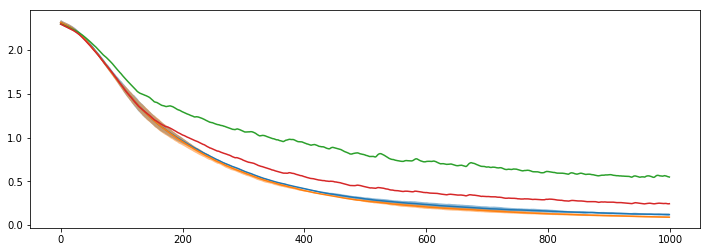

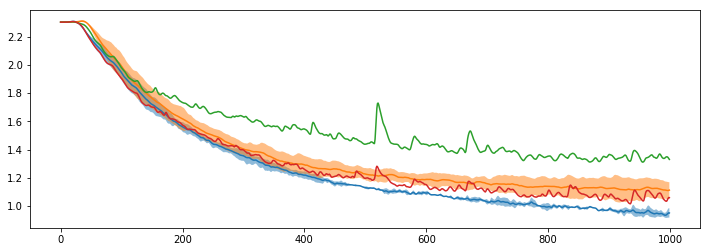

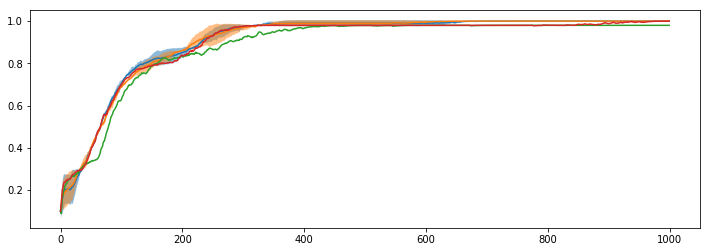

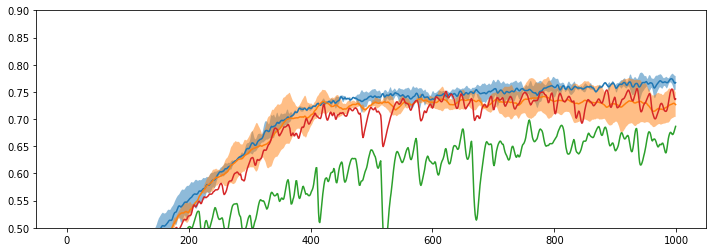

eta = 100

Epoch 1 of 1000 took 3.56s;
train loss:
data term: 2.33, constrain term: 0.00, full: 2.53
train acc: 10.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 2 of 1000 took 3.53s;
train loss:
data term: 2.34, constrain term: 0.00, full: 2.40
train acc: 6.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 3 of 1000 took 3.54s;
train loss:
data term: 2.33, constrain term: 0.00, full: 2.37
train acc: 12.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 4 of 1000 took 3.54s;
train loss:
data term: 2.33, constrain term: 0.00, full: 2.35
train acc: 10.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 5 of 1000 took 3.53s;
train loss:
data term: 2.32, constrain term: 0.00, full: 2.34
train acc: 14.00
test loss:
data term: 2.30, constrain term: 0.00
test acc: 10.10

Epoch 6 of 1000 took 3.53s;
train loss:
data term: 2.32, constrain term: 0.00, full: 2.33
train acc: 10.00
test loss:
data te

Epoch 49 of 1000 took 3.54s;
train loss:
data term: 2.10, constrain term: 0.00, full: 2.11
train acc: 34.00
test loss:
data term: 2.21, constrain term: 0.00
test acc: 22.54

Epoch 50 of 1000 took 3.53s;
train loss:
data term: 2.10, constrain term: 0.00, full: 2.11
train acc: 42.00
test loss:
data term: 2.21, constrain term: 0.00
test acc: 22.86

Epoch 51 of 1000 took 3.54s;
train loss:
data term: 2.10, constrain term: 0.00, full: 2.11
train acc: 42.00
test loss:
data term: 2.21, constrain term: 0.00
test acc: 23.10

Epoch 52 of 1000 took 3.54s;
train loss:
data term: 2.09, constrain term: 0.00, full: 2.09
train acc: 40.00
test loss:
data term: 2.20, constrain term: 0.00
test acc: 23.46

Epoch 53 of 1000 took 3.53s;
train loss:
data term: 2.09, constrain term: 0.00, full: 2.09
train acc: 40.00
test loss:
data term: 2.20, constrain term: 0.00
test acc: 23.73

Epoch 54 of 1000 took 3.53s;
train loss:
data term: 2.08, constrain term: 0.00, full: 2.10
train acc: 36.00
test loss:
data term: 

Epoch 97 of 1000 took 3.54s;
train loss:
data term: 1.81, constrain term: 0.00, full: 1.88
train acc: 68.00
test loss:
data term: 2.08, constrain term: 0.00
test acc: 38.89

Epoch 98 of 1000 took 3.54s;
train loss:
data term: 1.82, constrain term: 0.00, full: 1.84
train acc: 60.00
test loss:
data term: 2.08, constrain term: 0.00
test acc: 39.42

Epoch 99 of 1000 took 3.54s;
train loss:
data term: 1.81, constrain term: 0.00, full: 1.89
train acc: 68.00
test loss:
data term: 2.06, constrain term: 0.00
test acc: 40.17

Epoch 100 of 1000 took 3.54s;
train loss:
data term: 1.80, constrain term: 0.00, full: 1.87
train acc: 66.00
test loss:
data term: 2.04, constrain term: 0.00
test acc: 40.95

Epoch 101 of 1000 took 3.54s;
train loss:
data term: 1.82, constrain term: 0.00, full: 1.84
train acc: 62.00
test loss:
data term: 2.03, constrain term: 0.00
test acc: 41.18

Epoch 102 of 1000 took 3.54s;
train loss:
data term: 1.81, constrain term: 0.00, full: 1.82
train acc: 66.00
test loss:
data ter

Epoch 144 of 1000 took 3.54s;
train loss:
data term: 1.60, constrain term: 0.00, full: 1.66
train acc: 78.00
test loss:
data term: 1.88, constrain term: 0.00
test acc: 47.39

Epoch 145 of 1000 took 3.54s;
train loss:
data term: 1.59, constrain term: 0.00, full: 1.63
train acc: 74.00
test loss:
data term: 1.89, constrain term: 0.00
test acc: 48.92

Epoch 146 of 1000 took 3.53s;
train loss:
data term: 1.59, constrain term: 0.00, full: 1.66
train acc: 76.00
test loss:
data term: 1.90, constrain term: 0.00
test acc: 47.52

Epoch 147 of 1000 took 3.53s;
train loss:
data term: 1.58, constrain term: 0.00, full: 1.61
train acc: 82.00
test loss:
data term: 1.93, constrain term: 0.00
test acc: 45.50

Epoch 148 of 1000 took 3.54s;
train loss:
data term: 1.58, constrain term: 0.00, full: 1.79
train acc: 80.00
test loss:
data term: 1.92, constrain term: 0.00
test acc: 46.19

Epoch 149 of 1000 took 3.53s;
train loss:
data term: 1.55, constrain term: 0.00, full: 1.56
train acc: 82.00
test loss:
data 

Epoch 191 of 1000 took 3.54s;
train loss:
data term: 1.43, constrain term: 0.00, full: 1.55
train acc: 82.00
test loss:
data term: 1.75, constrain term: 0.00
test acc: 50.84

Epoch 192 of 1000 took 3.56s;
train loss:
data term: 1.43, constrain term: 0.00, full: 1.48
train acc: 80.00
test loss:
data term: 1.76, constrain term: 0.00
test acc: 49.96

Epoch 193 of 1000 took 3.53s;
train loss:
data term: 1.43, constrain term: 0.00, full: 1.55
train acc: 84.00
test loss:
data term: 1.76, constrain term: 0.00
test acc: 49.74

Epoch 194 of 1000 took 3.54s;
train loss:
data term: 1.42, constrain term: 0.00, full: 1.51
train acc: 82.00
test loss:
data term: 1.77, constrain term: 0.00
test acc: 48.88

Epoch 195 of 1000 took 3.54s;
train loss:
data term: 1.44, constrain term: 0.00, full: 1.50
train acc: 84.00
test loss:
data term: 1.78, constrain term: 0.00
test acc: 49.20

Epoch 196 of 1000 took 3.54s;
train loss:
data term: 1.42, constrain term: 0.00, full: 1.48
train acc: 80.00
test loss:
data 

Epoch 238 of 1000 took 3.53s;
train loss:
data term: 1.29, constrain term: 0.00, full: 1.31
train acc: 84.00
test loss:
data term: 1.71, constrain term: 0.00
test acc: 54.80

Epoch 239 of 1000 took 3.54s;
train loss:
data term: 1.27, constrain term: 0.00, full: 1.29
train acc: 88.00
test loss:
data term: 1.72, constrain term: 0.00
test acc: 54.28

Epoch 240 of 1000 took 3.54s;
train loss:
data term: 1.27, constrain term: 0.00, full: 1.34
train acc: 84.00
test loss:
data term: 1.73, constrain term: 0.00
test acc: 52.12

Epoch 241 of 1000 took 3.54s;
train loss:
data term: 1.25, constrain term: 0.00, full: 1.32
train acc: 86.00
test loss:
data term: 1.74, constrain term: 0.00
test acc: 49.08

Epoch 242 of 1000 took 3.54s;
train loss:
data term: 1.25, constrain term: 0.00, full: 1.27
train acc: 88.00
test loss:
data term: 1.75, constrain term: 0.00
test acc: 48.36

Epoch 243 of 1000 took 3.53s;
train loss:
data term: 1.26, constrain term: 0.00, full: 1.37
train acc: 86.00
test loss:
data 

Epoch 285 of 1000 took 3.53s;
train loss:
data term: 1.19, constrain term: 0.00, full: 1.32
train acc: 86.00
test loss:
data term: 1.66, constrain term: 0.00
test acc: 48.86

Epoch 286 of 1000 took 3.54s;
train loss:
data term: 1.21, constrain term: 0.00, full: 1.27
train acc: 86.00
test loss:
data term: 1.66, constrain term: 0.00
test acc: 50.62

Epoch 287 of 1000 took 3.54s;
train loss:
data term: 1.21, constrain term: 0.00, full: 1.29
train acc: 90.00
test loss:
data term: 1.66, constrain term: 0.00
test acc: 51.95

Epoch 288 of 1000 took 3.54s;
train loss:
data term: 1.22, constrain term: 0.00, full: 1.26
train acc: 86.00
test loss:
data term: 1.67, constrain term: 0.00
test acc: 52.84

Epoch 289 of 1000 took 3.53s;
train loss:
data term: 1.21, constrain term: 0.00, full: 1.32
train acc: 88.00
test loss:
data term: 1.70, constrain term: 0.00
test acc: 51.64

Epoch 290 of 1000 took 3.54s;
train loss:
data term: 1.19, constrain term: 0.00, full: 1.29
train acc: 88.00
test loss:
data 

Epoch 332 of 1000 took 3.54s;
train loss:
data term: 1.07, constrain term: 0.00, full: 1.52
train acc: 90.00
test loss:
data term: 1.71, constrain term: 0.00
test acc: 42.42

Epoch 333 of 1000 took 3.53s;
train loss:
data term: 1.07, constrain term: 0.00, full: 1.11
train acc: 88.00
test loss:
data term: 1.79, constrain term: 0.00
test acc: 34.32

Epoch 334 of 1000 took 3.54s;
train loss:
data term: 1.08, constrain term: 0.00, full: 1.12
train acc: 92.00
test loss:
data term: 1.82, constrain term: 0.00
test acc: 31.98

Epoch 335 of 1000 took 3.54s;
train loss:
data term: 1.09, constrain term: 0.00, full: 1.21
train acc: 90.00
test loss:
data term: 1.79, constrain term: 0.00
test acc: 34.18

Epoch 336 of 1000 took 3.54s;
train loss:
data term: 1.08, constrain term: 0.00, full: 1.28
train acc: 90.00
test loss:
data term: 1.71, constrain term: 0.00
test acc: 42.96

Epoch 337 of 1000 took 3.54s;
train loss:
data term: 1.08, constrain term: 0.00, full: 1.23
train acc: 90.00
test loss:
data 

Epoch 379 of 1000 took 3.54s;
train loss:
data term: 1.02, constrain term: 0.00, full: 1.08
train acc: 92.00
test loss:
data term: 1.61, constrain term: 0.00
test acc: 55.03

Epoch 380 of 1000 took 3.54s;
train loss:
data term: 1.01, constrain term: 0.00, full: 1.17
train acc: 94.00
test loss:
data term: 1.59, constrain term: 0.00
test acc: 58.10

Epoch 381 of 1000 took 3.53s;
train loss:
data term: 1.01, constrain term: 0.00, full: 1.09
train acc: 90.00
test loss:
data term: 1.58, constrain term: 0.00
test acc: 59.31

Epoch 382 of 1000 took 3.54s;
train loss:
data term: 1.02, constrain term: 0.00, full: 1.04
train acc: 92.00
test loss:
data term: 1.58, constrain term: 0.00
test acc: 60.23

Epoch 383 of 1000 took 3.53s;
train loss:
data term: 1.01, constrain term: 0.00, full: 1.18
train acc: 90.00
test loss:
data term: 1.57, constrain term: 0.00
test acc: 59.28

Epoch 384 of 1000 took 3.54s;
train loss:
data term: 1.02, constrain term: 0.00, full: 1.07
train acc: 90.00
test loss:
data 

Epoch 426 of 1000 took 3.54s;
train loss:
data term: 0.96, constrain term: 0.00, full: 1.12
train acc: 92.00
test loss:
data term: 1.55, constrain term: 0.00
test acc: 55.75

Epoch 427 of 1000 took 3.53s;
train loss:
data term: 0.95, constrain term: 0.00, full: 0.98
train acc: 94.00
test loss:
data term: 1.54, constrain term: 0.00
test acc: 57.61

Epoch 428 of 1000 took 3.54s;
train loss:
data term: 0.95, constrain term: 0.00, full: 1.03
train acc: 94.00
test loss:
data term: 1.54, constrain term: 0.00
test acc: 58.82

Epoch 429 of 1000 took 3.54s;
train loss:
data term: 0.94, constrain term: 0.00, full: 1.09
train acc: 94.00
test loss:
data term: 1.54, constrain term: 0.00
test acc: 58.78

Epoch 430 of 1000 took 3.54s;
train loss:
data term: 0.94, constrain term: 0.00, full: 1.10
train acc: 96.00
test loss:
data term: 1.53, constrain term: 0.00
test acc: 58.72

Epoch 431 of 1000 took 3.54s;
train loss:
data term: 0.95, constrain term: 0.00, full: 0.99
train acc: 96.00
test loss:
data 

Epoch 473 of 1000 took 3.54s;
train loss:
data term: 0.90, constrain term: 0.00, full: 1.06
train acc: 98.00
test loss:
data term: 1.53, constrain term: 0.00
test acc: 53.85

Epoch 474 of 1000 took 3.55s;
train loss:
data term: 0.90, constrain term: 0.00, full: 1.07
train acc: 94.00
test loss:
data term: 1.54, constrain term: 0.00
test acc: 53.17

Epoch 475 of 1000 took 3.54s;
train loss:
data term: 0.91, constrain term: 0.00, full: 1.05
train acc: 94.00
test loss:
data term: 1.54, constrain term: 0.00
test acc: 53.00

Epoch 476 of 1000 took 3.53s;
train loss:
data term: 0.91, constrain term: 0.00, full: 0.98
train acc: 94.00
test loss:
data term: 1.54, constrain term: 0.00
test acc: 53.20

Epoch 477 of 1000 took 3.54s;
train loss:
data term: 0.93, constrain term: 0.00, full: 1.08
train acc: 94.00
test loss:
data term: 1.53, constrain term: 0.00
test acc: 54.78

Epoch 478 of 1000 took 3.54s;
train loss:
data term: 0.93, constrain term: 0.00, full: 1.05
train acc: 92.00
test loss:
data 

Epoch 520 of 1000 took 3.54s;
train loss:
data term: 0.82, constrain term: 0.00, full: 0.91
train acc: 98.00
test loss:
data term: 1.53, constrain term: 0.00
test acc: 48.98

Epoch 521 of 1000 took 3.54s;
train loss:
data term: 0.82, constrain term: 0.00, full: 0.97
train acc: 98.00
test loss:
data term: 1.55, constrain term: 0.00
test acc: 47.58

Epoch 522 of 1000 took 3.54s;
train loss:
data term: 0.85, constrain term: 0.00, full: 1.00
train acc: 94.00
test loss:
data term: 1.54, constrain term: 0.00
test acc: 48.17

Epoch 523 of 1000 took 3.54s;
train loss:
data term: 0.85, constrain term: 0.00, full: 1.00
train acc: 96.00
test loss:
data term: 1.50, constrain term: 0.00
test acc: 51.70

Epoch 524 of 1000 took 3.54s;
train loss:
data term: 0.86, constrain term: 0.00, full: 0.95
train acc: 98.00
test loss:
data term: 1.48, constrain term: 0.00
test acc: 56.26

Epoch 525 of 1000 took 3.55s;
train loss:
data term: 0.84, constrain term: 0.00, full: 1.00
train acc: 96.00
test loss:
data 

Epoch 567 of 1000 took 3.54s;
train loss:
data term: 0.80, constrain term: 0.00, full: 0.92
train acc: 94.00
test loss:
data term: 1.52, constrain term: 0.00
test acc: 52.10

Epoch 568 of 1000 took 3.53s;
train loss:
data term: 0.79, constrain term: 0.00, full: 0.86
train acc: 98.00
test loss:
data term: 1.50, constrain term: 0.00
test acc: 54.68

Epoch 569 of 1000 took 3.54s;
train loss:
data term: 0.78, constrain term: 0.00, full: 0.90
train acc: 98.00
test loss:
data term: 1.48, constrain term: 0.00
test acc: 57.78

Epoch 570 of 1000 took 3.54s;
train loss:
data term: 0.78, constrain term: 0.00, full: 0.93
train acc: 98.00
test loss:
data term: 1.46, constrain term: 0.00
test acc: 60.11

Epoch 571 of 1000 took 3.54s;
train loss:
data term: 0.78, constrain term: 0.00, full: 0.90
train acc: 98.00
test loss:
data term: 1.48, constrain term: 0.00
test acc: 57.49

Epoch 572 of 1000 took 3.55s;
train loss:
data term: 0.77, constrain term: 0.00, full: 1.01
train acc: 98.00
test loss:
data 

Epoch 614 of 1000 took 3.54s;
train loss:
data term: 0.76, constrain term: 0.00, full: 0.83
train acc: 96.00
test loss:
data term: 1.43, constrain term: 0.00
test acc: 61.38

Epoch 615 of 1000 took 3.54s;
train loss:
data term: 0.75, constrain term: 0.00, full: 0.86
train acc: 98.00
test loss:
data term: 1.43, constrain term: 0.00
test acc: 61.13

Epoch 616 of 1000 took 3.54s;
train loss:
data term: 0.74, constrain term: 0.00, full: 0.92
train acc: 98.00
test loss:
data term: 1.42, constrain term: 0.00
test acc: 61.29

Epoch 617 of 1000 took 3.54s;
train loss:
data term: 0.73, constrain term: 0.00, full: 0.89
train acc: 98.00
test loss:
data term: 1.45, constrain term: 0.00
test acc: 57.06

Epoch 618 of 1000 took 3.54s;
train loss:
data term: 0.73, constrain term: 0.00, full: 0.87
train acc: 98.00
test loss:
data term: 1.49, constrain term: 0.00
test acc: 52.08

Epoch 619 of 1000 took 3.55s;
train loss:
data term: 0.74, constrain term: 0.00, full: 0.87
train acc: 100.00
test loss:
data

Epoch 661 of 1000 took 3.55s;
train loss:
data term: 0.72, constrain term: 0.00, full: 0.83
train acc: 100.00
test loss:
data term: 1.39, constrain term: 0.00
test acc: 63.72

Epoch 662 of 1000 took 3.55s;
train loss:
data term: 0.71, constrain term: 0.00, full: 0.86
train acc: 100.00
test loss:
data term: 1.38, constrain term: 0.00
test acc: 65.99

Epoch 663 of 1000 took 3.56s;
train loss:
data term: 0.72, constrain term: 0.00, full: 0.90
train acc: 100.00
test loss:
data term: 1.38, constrain term: 0.00
test acc: 65.84

Epoch 664 of 1000 took 3.56s;
train loss:
data term: 0.71, constrain term: 0.00, full: 0.81
train acc: 100.00
test loss:
data term: 1.38, constrain term: 0.00
test acc: 64.32

Epoch 665 of 1000 took 3.55s;
train loss:
data term: 0.71, constrain term: 0.00, full: 0.78
train acc: 100.00
test loss:
data term: 1.40, constrain term: 0.00
test acc: 62.56

Epoch 666 of 1000 took 3.55s;
train loss:
data term: 0.70, constrain term: 0.00, full: 0.82
train acc: 100.00
test loss:

Epoch 708 of 1000 took 3.57s;
train loss:
data term: 0.67, constrain term: 0.00, full: 0.75
train acc: 100.00
test loss:
data term: 1.42, constrain term: 0.00
test acc: 65.39

Epoch 709 of 1000 took 3.57s;
train loss:
data term: 0.67, constrain term: 0.00, full: 0.79
train acc: 100.00
test loss:
data term: 1.42, constrain term: 0.00
test acc: 64.05

Epoch 710 of 1000 took 3.56s;
train loss:
data term: 0.68, constrain term: 0.00, full: 0.93
train acc: 100.00
test loss:
data term: 1.41, constrain term: 0.00
test acc: 61.50

Epoch 711 of 1000 took 3.59s;
train loss:
data term: 0.67, constrain term: 0.00, full: 0.73
train acc: 100.00
test loss:
data term: 1.41, constrain term: 0.00
test acc: 58.87

Epoch 712 of 1000 took 3.57s;
train loss:
data term: 0.67, constrain term: 0.00, full: 0.87
train acc: 100.00
test loss:
data term: 1.43, constrain term: 0.00
test acc: 55.10

Epoch 713 of 1000 took 3.57s;
train loss:
data term: 0.69, constrain term: 0.00, full: 0.75
train acc: 100.00
test loss:

Epoch 755 of 1000 took 3.56s;
train loss:
data term: 0.65, constrain term: 0.00, full: 0.85
train acc: 100.00
test loss:
data term: 1.36, constrain term: 0.00
test acc: 69.00

Epoch 756 of 1000 took 3.56s;
train loss:
data term: 0.67, constrain term: 0.00, full: 0.83
train acc: 100.00
test loss:
data term: 1.38, constrain term: 0.00
test acc: 66.64

Epoch 757 of 1000 took 3.56s;
train loss:
data term: 0.68, constrain term: 0.00, full: 0.81
train acc: 100.00
test loss:
data term: 1.38, constrain term: 0.00
test acc: 64.56

Epoch 758 of 1000 took 3.56s;
train loss:
data term: 0.68, constrain term: 0.00, full: 0.90
train acc: 100.00
test loss:
data term: 1.39, constrain term: 0.00
test acc: 60.74

Epoch 759 of 1000 took 3.56s;
train loss:
data term: 0.66, constrain term: 0.00, full: 0.76
train acc: 100.00
test loss:
data term: 1.41, constrain term: 0.00
test acc: 56.02

Epoch 760 of 1000 took 3.57s;
train loss:
data term: 0.67, constrain term: 0.00, full: 0.76
train acc: 100.00
test loss:

In [ ]:
num_epochs = 1000
num_runs = 5
save_every = 10000

etas = [1, 0, 100, 10]
for eta in etas[2:]:
    train_losses[eta] = []
    train_accs[eta] = []
    
    test_losses[eta] = []
    test_accs[eta] = []

loss_function = nn.CrossEntropyLoss()

for run in range(num_runs):
    print('run', run+1)

    for j, eta in list(enumerate(etas))[(2 if run==0 else 0):]:
        print('eta =', eta)
        print()

        train_losses[eta].append([])
        train_accs[eta].append([])

        test_losses[eta].append([])
        test_accs[eta].append([])

        torch.manual_seed(run)
        torch.cuda.manual_seed(run)
        np.random.seed(run)

        model = ModelConvolutional(input_shape, output_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))
        #scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda k: ((num_epochs-k)/200 if k >= num_epochs-200 else 1))
    
        train_dataset_labelled, train_dataset_unlabelled, train_labels_labelled, train_labels_unlabelled = train_test_split(
            padded_train_data, np.array(train_loader.dataset.train_labels), train_size=50
        )
        
        train_loader_labelled = DataLoader(
            TensorDataset(
                torch.from_numpy(train_dataset_labelled).float() / 255, 
                torch.Tensor(train_labels_labelled).long()
            ),
            batch_size=batch_size, shuffle=True, **kwargs
        )
        train_loader_unlabelled = DataLoader(
            TensorDataset(
                torch.from_numpy(train_dataset_unlabelled).float() / 255, 
                torch.Tensor(train_labels_unlabelled).long()
            ),
            batch_size=batch_size, shuffle=True, **kwargs
        )
        
        for epoch in range(num_epochs):
            start_time = time()
    
            #scheduler.step()
    
            cum_loss_data = 0
            cum_loss_constrain = 0
            cum_loss_full = 0
            cum_acc = 0
            batch_count = 0

            model.train()
            train_iter_unlabelled = iter(train_loader_unlabelled)
            for X, y in train_loader_labelled:
                X, y = X.to(device), y.to(device)
                prediction = model(X)
                loss_data = loss_function(prediction, y)
                cum_loss_data += loss_data.item()
        
                if eta < 1e-15:
                    loss_constrain = torch.tensor(0., device=device)
                else:
                    loss_constrain = constrain_loss_function(
                        model, use_all_classes=False, batch_gen=train_iter_unlabelled
                    )
                cum_loss_constrain += loss_constrain.item()
        
                loss_full = loss_data + eta * loss_constrain
                cum_loss_full += loss_full.item()
            
                acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
                cum_acc += acc.item()
        
                optimizer.zero_grad()
                loss_full.backward()
                optimizer.step()
                batch_count += 1
            
            mean_train_loss_data = cum_loss_data / batch_count
            mean_train_loss_constrain = cum_loss_constrain / batch_count
            mean_train_loss_full = cum_loss_full / batch_count
            mean_train_acc = cum_acc / batch_count

            train_losses[eta][-1].append(mean_train_loss_data)
            train_accs[eta][-1].append(mean_train_acc)
        
            cum_loss_data = 0
            cum_loss_constrain = 0
            cum_acc = 0
            batch_count = 0

            model.eval()
            with torch.no_grad():
                for X, y in test_loader:
                    X, y = X.to(device), y.to(device)
                    prediction = model(X)
                    loss_data = loss_function(prediction, y)
                    cum_loss_data += loss_data.item()
        
                    acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
                    cum_acc += acc.item()
        
                    batch_count += 1
            
            mean_test_loss_data = cum_loss_data / batch_count
            mean_test_loss_constrain = cum_loss_constrain / batch_count
            mean_test_acc = cum_acc / batch_count

            test_losses[eta][-1].append(mean_test_loss_data)
            test_accs[eta][-1].append(mean_test_acc)
        
            print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
            print('train loss:')
            print(
                'data term: {:.2f}, constrain term: {:.2f}, full: {:.2f}'.format(
                    mean_train_loss_data, mean_train_loss_constrain, mean_train_loss_full
                )
            )
            print('train acc: {:.2f}'.format(mean_train_acc*100))
            print('test loss:')
            print(
                'data term: {:.2f}, constrain term: {:.2f}'.format(
                    mean_test_loss_data, mean_test_loss_constrain
                )
            )
            print('test acc: {:.2f}'.format(mean_test_acc*100))
            print()
        
            if (epoch+1) % save_every == 0:
                with open(name_prefix + mode_name + '/train_losses.pkl', 'wb') as f:
                    pickle.dump(np.array(train_losses[mode]), f)
                with open(name_prefix + mode_name + '/test_losses.pkl', 'wb') as f:
                    pickle.dump(np.array(test_losses[mode]), f)
                with open(name_prefix + mode_name + '/train_accs.pkl', 'wb') as f:
                    pickle.dump(np.array(train_accs[mode]), f)
                with open(name_prefix + mode_name + '/test_accs.pkl', 'wb') as f:
                    pickle.dump(np.array(test_accs[mode]), f)

                torch.save(model.state_dict(), name_prefix + mode_name + '/model.pt')

            if (epoch+1) % num_epochs == 0:
                alpha=0.1
                fig = plt.figure(figsize=(12, 4))
                for i in range(j+1 if run==0 else len(etas)):
                    curve = DataFrame(train_losses[etas[i]]).ewm(alpha=alpha, axis=1).mean()
                    plt.plot(curve.mean(axis=0))
                    plt.fill_between(
                        np.arange(curve.shape[1]),
                        curve.mean(axis=0) - curve.std(axis=0),
                        curve.mean(axis=0) + curve.std(axis=0),
                        alpha=0.5
                    )
                plt.show()
                fig = plt.figure(figsize=(12, 4))
                for i in range(j+1 if run==0 else len(etas)):
                    curve = DataFrame(test_losses[etas[i]]).ewm(alpha=alpha, axis=1).mean()
                    plt.plot(curve.mean(axis=0))
                    plt.fill_between(
                        np.arange(curve.shape[1]),
                        curve.mean(axis=0) - curve.std(axis=0),
                        curve.mean(axis=0) + curve.std(axis=0),
                        alpha=0.5
                    )
                plt.show()
                fig = plt.figure(figsize=(12, 4))
                for i in range(j+1 if run==0 else len(etas)):
                    curve = DataFrame(train_accs[etas[i]]).ewm(alpha=alpha, axis=1).mean()
                    plt.plot(curve.mean(axis=0))
                    plt.fill_between(
                        np.arange(curve.shape[1]),
                        curve.mean(axis=0) - curve.std(axis=0),
                        curve.mean(axis=0) + curve.std(axis=0),
                        alpha=0.5
                    )
                plt.show()
                fig = plt.figure(figsize=(12, 4))
                for i in range(j+1 if run==0 else len(etas)):
                    curve = DataFrame(test_accs[etas[i]]).ewm(alpha=alpha, axis=1).mean()
                    plt.plot(curve.mean(axis=0))
                    plt.fill_between(
                        np.arange(curve.shape[1]),
                        curve.mean(axis=0) - curve.std(axis=0),
                        curve.mean(axis=0) + curve.std(axis=0),
                        alpha=0.5
                    )
                plt.ylim(0.5, 0.9)
                plt.show()
            
#train_losses[mode] = np.array(train_losses[mode])
#test_losses[mode] = np.array(test_losses[mode])
#train_accs[mode] = np.array(train_accs[mode])
#test_accs[mode] = np.array(test_accs[mode])
    

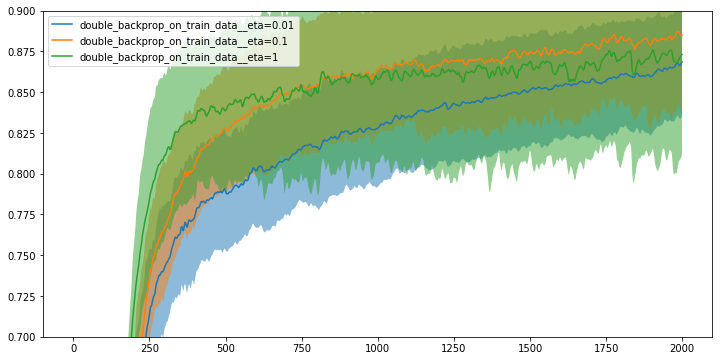

In [25]:
plt.figure(figsize=(12, 6))

alpha = 0.1
for mode in modes:
    curve = DataFrame(test_accs[mode]).ewm(alpha=alpha, axis=1).mean()
    plt.plot(curve.mean(axis=0))
    plt.fill_between(
        range(num_epochs),
        curve.mean(axis=0) - curve.std(axis=0),
        curve.mean(axis=0) + curve.std(axis=0),
        alpha=0.5
    )
plt.ylim(0.7, 0.9)
plt.legend(modes)

In [26]:
for mode in modes:
    print('{}: {:.2f} +- {:.2f}'.format(
        mode, 
        DataFrame(test_accs[mode]).ewm(alpha=alpha, axis=1).mean().mean(axis=0).max() * 100, 
        DataFrame(test_accs[mode]).ewm(alpha=alpha, axis=1).mean().std(axis=0)[
            np.argmax(DataFrame(test_accs[mode]).ewm(alpha=alpha, axis=1).mean().mean(axis=0))
        ] * 100, 
    ))

double_backprop_on_train_data__eta=0.01: 86.87 +- 3.26
double_backprop_on_train_data__eta=0.1: 88.73 +- 4.48
double_backprop_on_train_data__eta=1: 87.60 +- 6.11


In [26]:
train_loader.dataset.train_data.shape

torch.Size([60000, 28, 28])